# Main thing for using this repo

There are 5 things that this repo do:
- Data production and preprocessing
- Model training
- Model evaluation and real testing

I wish to make this repo as comprehinsible as possible, it likely that I will use different classes to achieve different things, specially beacause there are many outputs files happening. This will be connected with the workflow of the repo.



# Data production: ADAS and Goto CRM models

The ADAS model is used for Hydrogen, the physics of the model is described by [].
We used the cherab library from openADAS in python. 
The Goto model is used for Helium, the physics of the model is described by [].
We used the model itself provided by the authors, this runs on C, so we need a bit of interfacing to run it with python. 






### ADAS CRM engine

The file in the main directory CRM_ADAS.py is the "fundamental" file for obtaning inputs/outputs of the ADAS model for specifically hydrogen, deuterium in our case. It is a class named Deuterium, that basically takes a combination of $T_e$, $n_e$, $n_0$ and provides:

- Rates: Ionization rate, Recombination rate, CX Recombination rate, Power output due to excitation, and recombination. In the order: Irate, Rrate, CXrate, Pexc, Prec; as a numpy array. 


- Emissivities: Of Balmer lines: alpha [3 -> 2], beta [4 -> 2], gamma [5 -> 2], epsilon [7 -> 2]. It can also just provide specific Balmer lines if, for example if just the alpha and gamma line wants to be outputed then set as inputs balmer_lines = [3, 5]. If not provided the four lines are outputed. In the order: alpha, beta, gamma, epsilon; as a numpy array.

Note: unfortunately the libray used is not numpy like vectorized, if needed it can be vectorized. But producing the data for the whole grid is not a problem, it takes a few minutes.

Example below


In [1]:
import numpy as np
from CRM_ADAS import Deuterium

# create class instance
deu_crm = Deuterium()

# define Te, ne, no as arrays
# the units are eV, m^-3, m^-3
Te_ne_no = np.array([0.25, 1e19, 1e15])

Te_ne_no = np.array([49.075004,	4.238308e+18,	4.365388e+18])

# compute the rates
rates = deu_crm.compute_rates(Te_ne_no)
print('Irate, Rrate, CXrate, Pexc, Prec:')
print(str(rates) + ' ')
print('particles.m^3/s, particles.m^3/s, particles.m^3/s, W/m^3, W/m^3\n')

# compute emissivities
emis = deu_crm.compute_emissivites(Te_ne_no)
print('B_alpha, B_beta, B_gamma, B_epsilon: ')
print(str(emis) +  '')
print('#ph/s*m^3, #ph/s*m^3, #ph/s*m^3, #ph/s*m^3\n')


# for more information on the units etc. see the documentation of the CRM_ADAS.py file


Irate, Rrate, CXrate, Pexc, Prec:
[5.63348959e+23 2.37797985e+17 6.01902877e+23 9.57412291e+05
 4.16001128e+00] 
particles.m^3/s, particles.m^3/s, particles.m^3/s, W/m^3, W/m^3

B_alpha, B_beta, B_gamma, B_epsilon: 
[3.91334604e+22 5.90889585e+21 8.70240482e+20 5.99187285e+19]
#ph/s*m^3, #ph/s*m^3, #ph/s*m^3, #ph/s*m^3



### Goto CRM engine

For the Goto model, a $T_e$, $n_e$ is provided and we obtained the LRT 728/668, 706/668. Since the file is C and slighlty complicated for the purpose of this nb, we will point the file in: irates_jaime.c, this file takes a csv of two columns, Te, ne, without headers and outputes a csv file with Te, ne, LRT 728/668, LRT 706/668. 

Next we will show how to produce a whole data set for ADAS and Goto models. 

## Production of "raw" data

In [7]:

import numpy as np
import pandas as pd
from rawdata_gen import data_gen
from IPython.display import display
import pyarrow.parquet as pq

Te_range = [0.200001, 80.0] # eV
ne_range = [1e18, 1e20] # m^-3
no_range = [1e15, 1e19] # m^-3

pressure_limit = 3e21 # eV * m^-3 -> 2*Te*ne

# NOTE: the number of samples is not the number of samples in the final dataset
# the final dataset will have less samples because of the pressure limit
# this specific Irate and Rrate is 50% to 60% of the total number of samples
# inputed in the beginning
# this scaling of 50% to 60% applies when the number of samples is large
# for small number of samples the scaling is different
# this has to do with the fact, here the LatinHypercube sampling is used
# and there is some randomness in the sampling
# this can be seen in the rawdata_gen.py file at line 80

# the ranges of Te, ne, no can be changes, and also the way to apply limits if shown in line ~80 in the rawdata_gen.py file
# example:
# self.data = self.data[[a and b and c for a, b, c in zip(self.data[:,8] >= Irate_lower_limit, self.data[:,8] <= Irate_upper_limit,\
#  self.data[:,9] >= Rrate_lower_limit)]]
# simply add more a, b, c, d, ... and change the limits for the specific limits. 
# take into account that the index of the category (ex. Irate_lowe_limit) for specifiying the limits. 


num_samples = 1000
num_samples = int(num_samples/0.5) # this 0.6 can be changed. 

data = data_gen(Te_range, ne_range, no_range, pressure_limit, num_samples,\
     Brec3_limit=[0.0, 0.95],\
        Rrate_limit = [1e-12, 1e30], \
            Irate_limit = [1e-12, 1e30] )

df = data.get_data_pd()


display(df)



number of samples after applying pressure limit: 1910

 number of samples after applying Irate (rec fraction), Rrate limits: 1250

Output of the c file: 
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1250
 DONE
 c file for He ratios run done. Name of temporary file for data: temp_tene_cfile.csv 
 this file can be ignored or deleted


,emi_3-2,emi_4-2,emi_5-2,emi_7-2,Te,ne,no,Ion_degree,Irate,Rrate,CXrate,Pexc,Prec,728/706,728/668,Brec3/B3,IrateRrate
0,5.175864e+20,6.015760e+19,8.450062e+18,4.223905e+17,7.767186,9.165517e+18,9.727994e+16,0.989498,4.308880e+21,6.856106e+18,1.438876e+22,1.318687e+04,25.140934,0.123905,0.209378,8.727082e-04,4.315737e+21
1,3.399939e+20,2.939871e+19,3.477570e+18,2.726853e+17,28.652630,4.742855e+19,7.650846e+15,0.999839,9.806118e+21,5.119156e+19,9.604925e+21,1.313280e+04,502.113623,0.466962,0.115136,6.314577e-03,9.857310e+21
2,2.833250e+20,5.435948e+19,1.077358e+19,6.078601e+17,6.642162,1.505510e+18,3.344444e+17,0.818232,1.489889e+21,2.079874e+17,7.690897e+21,6.364483e+03,0.717319,0.138743,0.469036,4.683336e-05,1.490097e+21
3,1.731055e+19,2.357961e+18,4.583140e+17,5.332212e+16,3.690194,6.032389e+18,2.245239e+16,0.996292,7.647003e+19,6.085895e+18,1.665428e+21,4.627648e+02,16.753927,0.087388,0.259851,2.876332e-02,8.255592e+19
4,6.794447e+20,1.342714e+20,2.775517e+19,1.603784e+18,6.606381,1.288282e+18,9.375493e+17,0.578787,3.491922e+21,1.527098e+17,1.841369e+22,1.520771e+04,0.525897,0.142706,0.498276,1.429948e-05,3.492075e+21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,1.472445e+21,2.717915e+20,4.825866e+19,3.425433e+18,25.349924,1.800697e+18,4.350221e+17,0.805422,1.610747e+22,8.415258e+16,1.976531e+22,3.341122e+04,0.727560,0.254914,0.419018,2.589966e-06,1.610756e+22
1246,2.290000e+23,2.279091e+22,2.677054e+21,1.613746e+20,67.781887,2.208447e+19,6.431242e+18,0.774467,5.113921e+24,4.525825e+18,5.206835e+24,7.126540e+06,118.979977,0.775788,0.145774,6.619288e-07,5.113926e+24
1247,3.788647e+19,3.719141e+18,5.047533e+17,5.610549e+16,26.751348,2.567177e+19,1.243116e+15,0.999952,7.840745e+20,1.612251e+19,8.223828e+20,1.197389e+03,147.404691,0.361042,0.133030,1.851049e-02,8.001970e+20
1248,1.588331e+21,1.766843e+20,2.208246e+19,1.216066e+18,19.678132,1.185009e+19,1.043713e+17,0.991269,2.254374e+22,4.668186e+18,2.824642e+22,4.252415e+04,32.177669,0.231446,0.174081,1.427389e-04,2.254841e+22


In [8]:
# get min of each value and print it
min_Te = df['Te'].min()
min_ne = df['ne'].min()
min_no = df['no'].min()
min_Irate = df['Irate'].min()
min_Rrate = df['Rrate'].min()
min_IrateRrate = df['IrateRrate'].min()

# get max of each value and print it
max_Te = df['Te'].max()
max_ne = df['ne'].max()
max_no = df['no'].max()
max_Irate = df['Irate'].max()
max_Rrate = df['Rrate'].max()
max_IrateRrate = df['IrateRrate'].max()

print('Te = {} to {}'.format(min_Te, max_Te))
print('ne = {:.4E} to {:.4E}'.format(min_ne, max_ne))
print('no = {:.4E} to {:.4E}'.format(min_no, max_no))
print('Irate = {:.4E} to {:.4E}'.format(min_Irate, max_Irate))
print('Rrate = {:.4E} to {:.4E}'.format(min_Rrate, max_Rrate))
print('IrateRrate = {:.4E} to {:.4E}'.format(min_IrateRrate, max_IrateRrate))


Te = 0.8283791259431333 to 79.97971568206007
ne = 1.0000E+18 to 9.9714E+19
no = 1.0001E+15 to 9.9822E+18
Irate = 3.6590E+15 to 7.2099E+24
Rrate = 1.1053E+16 to 4.7586E+21
IrateRrate = 3.6962E+17 to 7.2100E+24


### Data save to csv or PARQUET  (to be implemented)

The data frame can be save it to csv, and then be read again. To modify the functions go to the fiel ``rawdata_gen.py``. The datasets are save in the folder ``raw_datasets``. Those csv files are just too chunky and old, so if you see everything change to parquet, that is the reason. 

In [4]:
filename = 'test_data_set_with_rec_3.parquet'
data.save_data_pd(filename)

In case a saved data set want to be read again, the function ``read_csv`` can be used. I put in the folder ``raw_datasets`` the dataset that I used for training the models in the internship.

In [5]:
print(filename)
df = pd.read_parquet(filename)
display(df)

test_data_set_with_rec_3.parquet


,emi_3-2,emi_4-2,emi_5-2,emi_7-2,Te,ne,no,Ion_degree,Irate,Rrate,CXrate,Pexc,Prec,728/706,728/668,Brec3/B3
0,2.538176e+20,2.994260e+19,8.425015e+18,2.246609e+18,8.527557,8.559763e+19,9.035191e+15,0.999894,5.813258e+21,5.734140e+20,1.288925e+22,1.048491e+04,2154.284280,0.200063,0.105701,0.164477
1,1.824311e+20,2.939428e+19,1.027436e+19,2.803490e+18,1.946674,3.027124e+19,8.061239e+17,0.974061,6.629167e+20,3.678977e+20,2.287785e+23,6.666444e+03,850.969382,0.060871,0.131984,0.268207
2,5.590381e+19,6.757974e+18,1.508347e+18,2.396595e+17,2.317278,9.619588e+18,3.024170e+17,0.969521,1.902413e+20,2.628003e+19,2.948220e+22,1.901119e+03,64.311858,0.067788,0.211140,0.047541
3,8.222993e+21,1.139940e+21,3.977625e+20,1.111038e+20,2.448652,2.299108e+20,3.397174e+18,0.985439,1.389747e+23,2.068463e+22,8.109524e+24,5.165590e+05,46764.875030,0.102171,0.088176,0.345084
4,7.760228e+16,3.403380e+16,2.182116e+16,8.917407e+15,1.220559,1.195643e+18,4.792628e+16,0.961461,1.372352e+16,6.883384e+17,4.340502e+20,7.702495e-01,1.585697,0.111469,0.571992,0.826250
5,2.253818e+21,6.341224e+20,2.597117e+20,7.730670e+19,1.817931,1.511503e+20,4.890900e+17,0.996775,1.900202e+21,1.325997e+22,6.717506e+23,1.285240e+04,28792.855970,0.079078,0.089852,0.939239
6,5.572765e+22,3.634540e+21,6.778040e+20,9.608285e+19,2.601135,2.100044e+20,2.741390e+19,0.884533,1.352017e+24,1.553510e+22,6.136299e+25,4.844390e+06,35758.984412,0.104225,0.089631,0.037383
7,5.626443e+18,7.992535e+17,1.598456e+17,2.447736e+16,6.311618,6.505855e+18,1.858764e+15,0.999714,3.564632e+19,4.188936e+18,1.813881e+20,1.324935e+02,13.966533,0.111137,0.247492,0.051492
8,1.602139e+22,1.389667e+21,3.717546e+20,8.436838e+19,2.188984,1.804531e+20,1.648579e+19,0.916290,2.668871e+23,1.450437e+22,2.939696e+25,1.272752e+06,32362.006022,0.090891,0.089620,0.132244
9,8.720720e+18,4.368929e+18,2.052237e+18,6.464057e+17,1.394765,1.113002e+19,6.744274e+16,0.993977,1.090195e+18,6.721919e+19,6.038305e+21,2.740772e+01,151.772847,0.057187,0.205501,0.942871


In [21]:
#df_fulldata = pd.read_csv('something.csv')
#display(df_fulldata)

### Visualizing the data

As for simple preprocessing of raw data the pressure limit, Irate, Rrate cap are apply here is the main thing here, now the dataframe can be use to inspect the data and do some simple plots of histograms. 

Simple functions to visualize the data are given next. 

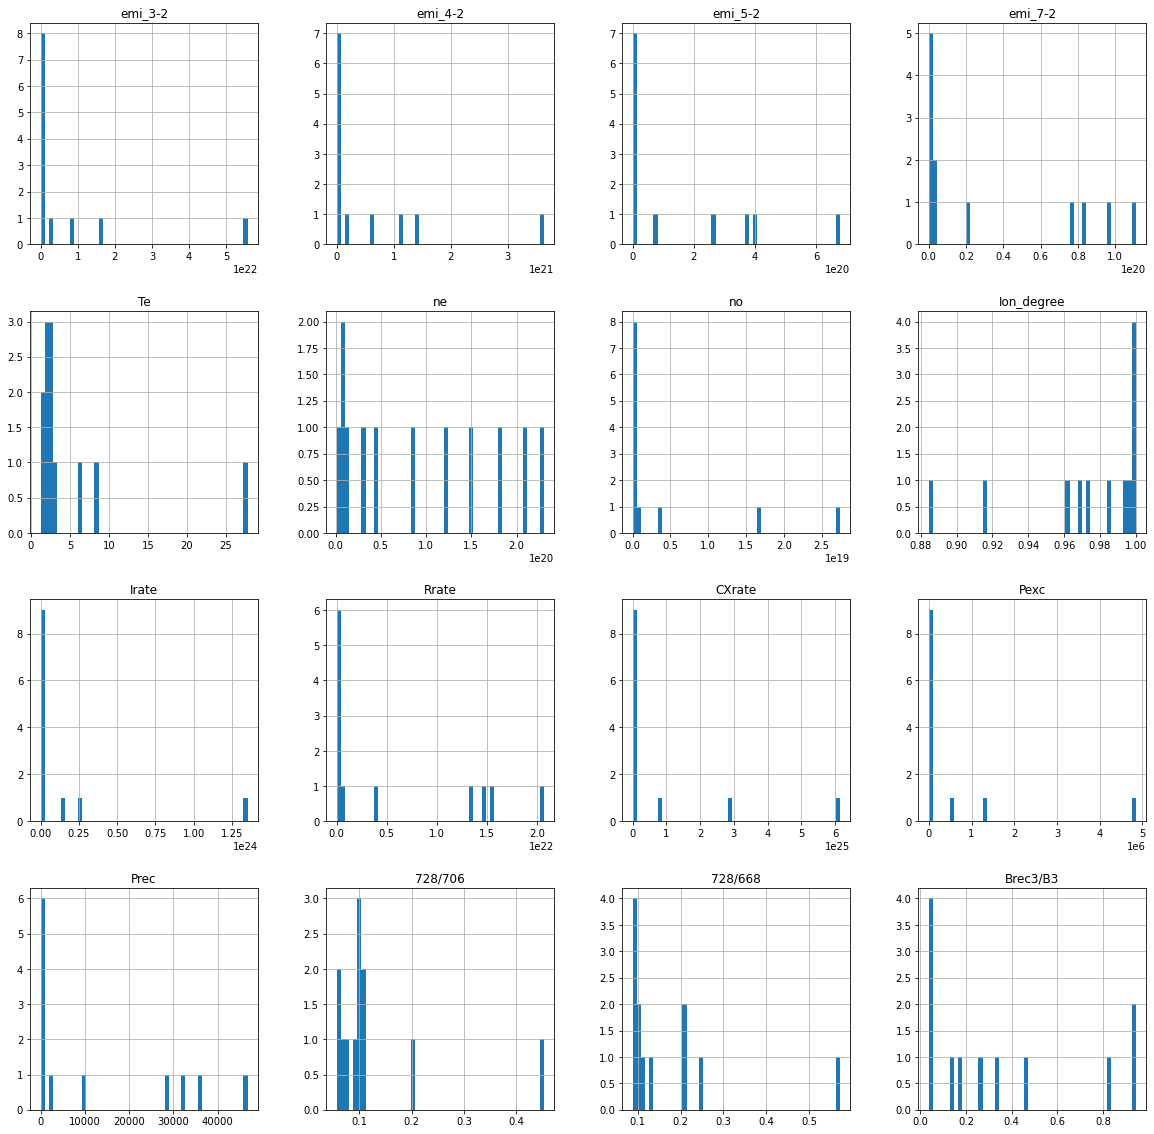

In [7]:
histograms = df.hist(bins=50, figsize=(20,20))

Preprocessing of the data, as log10 similar can be done to visualize to visualize the distrubution of the data.

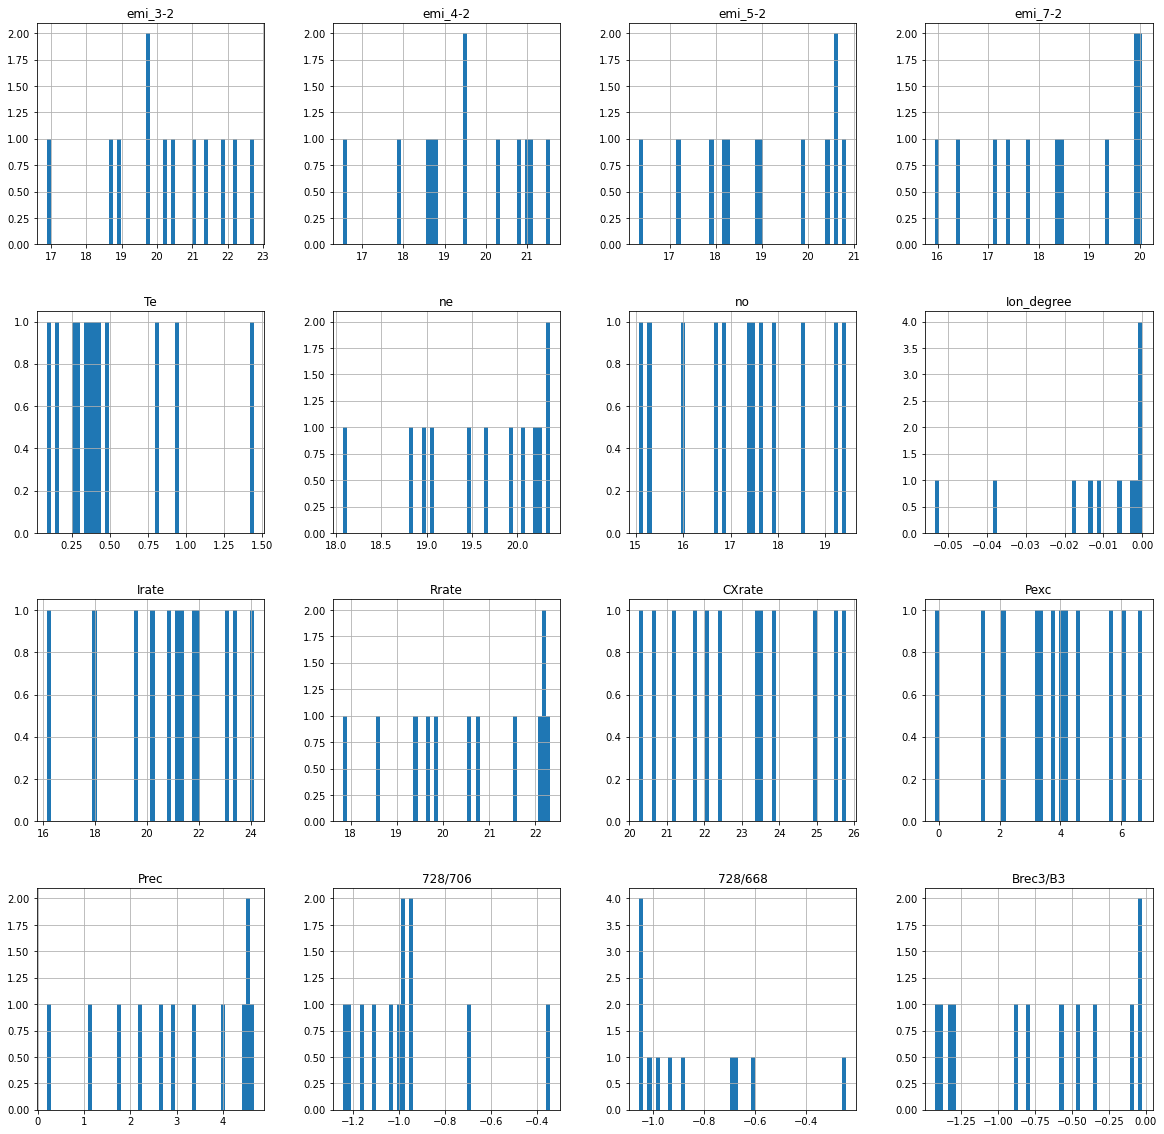

In [8]:
df_log10 = np.log10(df)
histograms_log10 = df_log10.hist(bins=50, figsize=(20,20))

## Data division

The data is divided into train, validation and test sets. The way I generated the three different datasets is simply producing three independent datasets, with the amount of data I want to have in each set. Since the LatinHypercube sampling is random, the three datasets are independent. There might be a better way to do this, but this is the way I did it. 

I will include a simple function with inputa bthe percetanges or numbers of samples for each data sets, and it saves to csv of the three datasets. At least for the way I did it, a data set has a name: ex. ``dataset_1``. And the the three datasets are saved as ``dataset_1_TRAIN.csv``, ``dataset_1_VAL.csv``, ``dataset_1_TEST.csv`` in the folder: ``raw_datasets``. 

In [4]:
import numpy as np
import pandas as pd
from rawdata_gen import data_gen
from IPython.display import display
import pyarrow.parquet as pq

dataset_name = 'raw_datasets/dataset_exp_13'
part_data = ['num_samples', [80, 10, 10]]
part_data = ['percents', int(2e5/0.95), [80, 10, 10]]


Te_range = [0.200001, 80.0] # eV
ne_range = [1e18, 1e20] # m^-3
no_range = [1e15, 1e19] # m^-3
pressure_limit = 3e21 # eV * m^-3 -> 2*Te*ne

Brec3_limit=[0.0, 1.00]
Rrate_limit = [1e-12, 1e30]
Irate_limit = [1e-12, 1e30] 


def train_test_val_save_datasets(dataset_name, part_data, filetype ='parquet'):

    # A proper "error dealing" should be implemented here

    # direcly specify the number of samples for train, test, val
    if part_data[0] == 'num_samples':

        num_samples_train = part_data[1][0]
        num_samples_test = part_data[1][1]
        num_samples_val = part_data[1][2]

    # spcify the total number of samples, and the percentages for train, test, val
    elif part_data[0] == 'percents':

        num_samples_train = int(part_data[1] * part_data[2][0] / 100)
        num_samples_test = int(part_data[1] * part_data[2][1] / 100)
        num_samples_val = int(part_data[1] * part_data[2][2] / 100)

    if filetype == 'parquet':

        ext = '.parquet'

    elif filetype == 'csv':

        ext = '.csv'


    data_train = data_gen(Te_range, ne_range, no_range, pressure_limit, num_samples_train,\
                            Brec3_limit=Brec3_limit,\
                                Rrate_limit = Rrate_limit, \
                                    Irate_limit = Irate_limit )
    data_train.save_data_pd(dataset_name + '_TRAIN' + ext, filetype)

    data_test = data_gen(Te_range, ne_range, no_range, pressure_limit, num_samples_test, \
                            Brec3_limit = Brec3_limit,\
                                Rrate_limit = Rrate_limit, \
                                    Irate_limit = Irate_limit )
    data_test.save_data_pd(dataset_name + '_TEST' + ext, filetype)
    
    data_val = data_gen(Te_range, ne_range, no_range, pressure_limit, num_samples_val,\
                            Brec3_limit = Brec3_limit,\
                                Rrate_limit = Rrate_limit, \
                                    Irate_limit = Irate_limit )
    data_val.save_data_pd(dataset_name + '_VAL' + ext, filetype)
    


# NOTE:
# the number of samples for train, test, val is not the number of samples in the final dataset
# the final dataset will have less samples because of the pressure limit and so forth


# Of course, you can also produce a main dataset, and then split it into train, test, val. 

train_test_val_save_datasets(dataset_name, part_data)

number of samples after applying pressure limit: 159787

 number of samples after applying Irate (rec fraction), Rrate limits: 159787

Output of the c file: 
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
86

# Preprocessing of the data 

Actually the preprocessing is done in the same operation that when a model is being train. Therefore I will start with the model training section and explain everything there.

# Model training

Every aspect of training is set up by a configuration file/dictionary. Normally, you provide a configuration file ``config.json`` or ``config.yaml``. The configuration file is a dictionary with the following keys

```python

sweep_configuration = {
    'method': 'grid',
    'name': 'sweep',
    'metric': {'goal': 'minimize', 'name': 'val_loss'},
    'parameters':
    {
        'batch_size': {'values': [10000]}, #SWEEPED

        'epochs': {'values': [100]},  #SWEEPED

        'dataset' : {'value': 'dataset_exp4/adasH_gotoHe_crm_LHS_IRrate_'},

        'inputs_labels' : { 'value' : ['Te', 'ne', 'emi_5-2']}, #Da,Dg  // Da, Db, Dg

        'inputs_prepro' : { 'value' : [1, 3, 3]},

        'inputs_scaler' : { 'value' : 'StandardScaler'},

        'outputs_labels' : { 'value' : ['no', 'Irate']},

        'outputs_prepro' : { 'value' : [3, 3]},

        'outputs_scaler' : { 'value' : 'MinMaxScaler'},

        'min_max_scale' : { 'value' : (0, 1)},

        'model' : { 'values' : ['MLP_BNN_model_Denseflipout_2']}, # 'MLP_NN_MCdropout' MLP_NN_simple

        'last_bayes_layer' : {'values': [100]},

        'l2_regularizer' : { 'value' : 1e-9},

        'dropout_p' : { 'value' : 0.01},

        'dropout_layers' : { 'value' : [3, 4]},

        'gau_noise': {'values': [0.01, 0.02, 0.05]},

        'gau_noise_H': {'values': [0.01]},

        'gau_noise_He': {'values': [0.09]},

        'num_nodes' : { 'values' : [100]},

        'num_layers' : { 'values' : [5]},

        'optimizer' : { 'value' : 'adam'},

        'activation_fn' : { 'value' : 'relu'},

        'loss_fn' : { 'value' : 'mse'},

        'earlystopping_patience' : { 'value' : 4}


     }
}

```

Lets go in order:

I used and I recommend using for training the application call weight and biases wandb (https://docs.wandb.ai/quickstart).

This example dictionary for doing grid sweeps of training using the wandb log. Basically the training configuration is provided, and the for certain hyperparameters you want to sweep, you provide the different values you want to sweep on. 

When it has ``value`` in the key this value is not sweep and is just a single value. 
ex.
```python   
'optimizer' : { 'value' : 'adam'}
```
The optimizer is not sweeped, and the value is just 'adam'.

When it has ``values`` in the key this value is sweeped.
```python   
'gau_noise': {'values': [0.01, 0.02, 0.05]}
```

The gau_noise is sweeped over the values 0.01, 0.02, 0.05. So there will be three different models trained with these values.



## Definition and preprocessing of the inputs and outputs of the model

For now lets forget the wandb and sweep stuff and do a pure local training explanation and example. 

I will explain the keys relate to input and output data, and there preprocessing. 

- ``dataset`` : 

the file location of the dataset as string, you provide the name of the dataset, and the code will use the ``dataset_name_TRAIN.csv``, ``dataset_name_TEST.csv`` and ``dataset_name_VAL.csv``. 

ex.
    
```python
    'dataset' : {'value': 'dataset_exp4/adasH_gotoHe_crm_LHS_IRrate_'}
```


- ``inputs_labels`` : 

the inputs of the model, as a list of strings. The strings are the names of the columns of the dataset. 

ex.
    
```python
    'inputs_labels' : { 'value' : ['Te', 'ne', 'emi_5-2']}, 
```

- ``inputs_prepro`` : 

the preprocessing to apply to each input of the model. If 'log10' is apply it will apply log10 to that input. If an integer is provide it will apply the root of that integer. So for 1, it will simply be the same input, for 2 it will be the square root, for 3 the cube root, etc. This is apply in a list of the same order as the inputs_labels. 

ex.
    
```python
    'inputs_prepro' : { 'value' : [1, 3, 3]},
```

So, here 'Te' will not be preprocessed, 'ne' will be cube root, and 'emi_5-2' will be cube root.

- ``inputs_scaler`` :

After applying the preprocessing, the data is scaled to standarize the data. The options are 'StandardScaler' (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and 'MinMaxScaler' (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). There are a few more, but I have not tested them. I recommend using 'StandardScaler' for the inputs. 

ex.
    
```python
    'inputs_scaler' : { 'value' : 'StandardScaler'},
```

- ``gau_noise`` :

Gaussian noise percentage to add to each input, in order of the inputs_labels. This is just for training, not for validation, testing or real use.

ex.
    
```python
    'gau_noise': {'values': [0.01, 0.02, 0.05]},
```

- ``outputs_labels`` :

the outputs of the model, as a list of strings. The strings are the names of the columns of the dataset.

ex.
    
```python
    'outputs_labels' : { 'value' : ['no', 'Irate']},
```

- ``outputs_prepro`` :

the preprocessing to apply to each output of the model. If 'log10' is apply it will apply log10 to that output. If an integer is provide it will apply the root of that integer. So for 1, it will simply be the same output, for 2 it will be the square root, for 3 the cube root, etc. This is apply in a list of the same order as the outputs_labels.

ex.
    
```python
    'outputs_prepro' : { 'value' : [3, 3]},
```

So, here 'no' will be cube root, and 'Irate' will be cube root.

- ``outputs_scaler`` :

After applying the preprocessing, the data is scaled to standarize the data. The options are 'StandardScaler' (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and 'MinMaxScaler' (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). There are a few more, but I have not tested them. I recommend using 'MinMaxScaler' for the outputs.

ex.
    
```python
    'outputs_scaler' : { 'value' : 'MinMaxScaler'},
```

- ``min_max_scale`` :

This is the range of the scaling. For example, if you want the outputs to be between 0 and 1, you provide (0, 1). If you want the outputs to be between -1 and 1, you provide (-1, 1). It will be the same for all the outputs. MinMaxScaler with range (0, 1) is what I used and recommend using. 

ex.
    
```python
    'min_max_scale' : { 'value' : (0, 1)},
```

Grabbing the data for training, applying the preprocessing, etc. is done in the python file ``data_loading_preprocessing.py``. Specifically the function ``grab_data_preprocessing_2``.


Given that standarising, minmax, etc. rely on the input data values of the training dataset, these recipes for preprocessing need to be saved, for later application on experimental data. The way I did this is by saving/having the configuration file and the recipes in a ``.yaml`` file, also storing the recipes in sklearn pipelines. This is done by the functions ``verify_yaml``, ``get_scalers``. 


Finally the functions ``data_coder`` (preprocessing inputs) and ``data_decoder`` (outprocessing outputs) apply the recipes to the inputs/outputs in training and also for later use. Maybe there is a better way to do this.

The very specifics of how this work, I will explaining the the testing section. Although I have to admit, that I forgot a bit how it works, but I know it works. By checking the code it is pretty clear to figure out how it works in case you need to change something.


In [7]:
# Author: Jaime Caballero
# Date: 13-10-2022

# general modules

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tensorflow as tf
#from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from numpy import asarray
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score as r2_score_metric
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
import datetime
#import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras import backend as K
#import scipy.io as sio
import time
import wandb
from wandb.keras import WandbCallback
import math


# helper modules

import models
import data_loading_preprocessing as data

sweep_configuration = {
    'method': 'grid',
    'name': 'sweep',
    'metric': {'goal': 'minimize', 'name': 'val_loss'},
    'parameters':
    {
        'batch_size': {'values': [1000]}, #SWEEPED

        'epochs': {'values': [100]},  #SWEEPED

        'dataset' : {'value': 'raw_datasets/dataset_sample_rec3_'}, # dataset_name = 'raw_datasets/dataset_sample_rec3'

        'inputs_labels' : { 'value' : ['emi_3-2', 'emi_5-2']}, #Da,Dg  // Da, Db, Dg

        'inputs_prepro' : { 'value' : [3, 3]},

        'inputs_scaler' : { 'value' : 'StandardScaler'},

        'outputs_labels' : { 'value' : ['Irate']},

        'outputs_prepro' : { 'value' : [3]},

        'outputs_scaler' : { 'value' : 'MinMaxScaler'},

        'min_max_scale' : { 'value' : (0, 1)},

        'model' : { 'values' : ['MLP_BNN_model_Denseflipout_2']}, # 'MLP_NN_MCdropout' MLP_NN_simple

        'last_bayes_layer' : {'values': [100]},

        'l2_regularizer' : { 'value' : 1e-9},

        'dropout_p' : { 'value' : 0.01},

        'dropout_layers' : { 'value' : [3, 4]},

        'gau_noise': {'values': [0.05, 0.05]},

        'gau_noise_H': {'values': [0.01]},

        'gau_noise_He': {'values': [0.09]},

        'num_nodes' : { 'values' : [100]},

        'num_layers' : { 'values' : [5]},

        'optimizer' : { 'value' : 'adam'},

        'activation_fn' : { 'value' : 'relu'},

        'loss_fn' : { 'value' : 'mse'},

        'earlystopping_patience' : { 'value' : 4},

        'folder_save_model' : { 'value' : 'new_models/'}


     }
}

In [8]:
##### THE MAIN DATASET I USED: 'dataset' : {'value': 'raw_datasets/adasH_gotoHe_crm_LHS_IRrate_'}, #####
##### IS NOT IN THE REPOSITORY BECAUSE IT IS TOO BIG. #####
##### ASK TO SEND IT TO YOU IF YOU WANT TO TRY IT, BUT... I GUESS YOU WILL USE THE ONE WITH THE NEW MODEL #####


print("###### LOADING DATASET ######")
print("###### no sweep on data preprocessing ######")
inputs_labels = sweep_configuration['parameters']['inputs_labels']['value']
inputs_prepro = sweep_configuration['parameters']['inputs_prepro']['value']
inputs_scaler = StandardScaler() if sweep_configuration['parameters']['inputs_scaler']['value'] == 'StandardScaler' else MinMaxScaler()

outputs_labels = sweep_configuration['parameters']['outputs_labels']['value']
outputs_prepro = sweep_configuration['parameters']['outputs_prepro']['value']
outputs_scaler = MinMaxScaler(feature_range=sweep_configuration['parameters']['min_max_scale']['value']) \
                                    if sweep_configuration['parameters']['outputs_scaler']['value'] == 'MinMaxScaler' else StandardScaler()

X_train_real_unique, y_train_real, \
X_train, y_train, \
X_val, y_val, \
X_test, y_test, \
transform_input, inverse_input, \
transform_output, inverse_output = data.grab_data_preprocessing_2(inputs_labels, inputs_prepro, inputs_scaler, \
                                                                outputs_labels, outputs_prepro, outputs_scaler, \
                                                                data_folder=sweep_configuration['parameters']['dataset']['value'])


print("###### DATASET LOADED ######")
print("###### no sweep on data preprocessing ######")
print("###### same datapreprocessing will be use across the sweep ######")

###### LOADING DATASET ######
###### no sweep on data preprocessing ######
----PARQUET FILES FOUND-----
###### DATASET LOADED ######
###### no sweep on data preprocessing ######
###### same datapreprocessing will be use across the sweep ######


Here dataset is loaded, inputs outputs pre/post processing is defined. The scaling or transformations to inputs and outputs are defined. and save to transform_input functions. The reason for X_train_real_unique and X_train has to do with the weird way I had to apply the different Gaussian noise to different inputs. I will explain that in the next section. 

## Training hyperparameters on data (Gaussian noise) 

The gaussian noise... we know it is very important. Also you remember that applying different gaussian noise is tricky. 

Here goes the history. I know I havent explain the training itself, but I will do it later. 

First, you can provide Gaussian noise to the inputs with standard tensorflow functions, but... it will apply the same Gaussian noise equally to all the inputs. So, if you have 3 inputs, and you want to apply Gaussian noise to all of them, you can do it. But if you want to apply different Gaussian noise to each input, you can not do it. At least not with the standard functions. 

Before the next, let me explain a bit how the training works.

An epoch of training is one full sweep of training on the training dataset. We need to do multiple of this to train the model. Once you declare the training data it can not change during a full training. 

So, what I do is that I train the model for just one epoch, and I provide an input data with different Gaussian noise en each input. And I basically do this for each epoch. So, I have to provide "different data" for each epoch. Ugly but it works, you can definetely improve this. 

The standarization preprocessing is done with the not noisy data.

ex. 

```python 

  for i in range(num_epochs):

        # Here I grab a full copy of the training data in real space (no preprocessing). 
        X_train_real = X_train_real_unique.copy()

        # Here I apply the different Gaussian noise to each input.
        # wandb.config.gau_noise is the gau_noise input in the config dictionary. 
        X_train_fit =  data.data_encoder(X_train_real + X_train_real * wandb.config.gau_noise * np.random.randn(X_train_real.shape[0], X_train_real.shape[1]), inputs_prepro, transform_input)[0]

        # Here I train the model for one epoch.
        history = model.fit(X_train_fit, y_train, batch_size = batch_size, verbose=2, validation_data = (X_val, y_val), shuffle = True, epochs=1, validation_batch_size = 20000, callbacks=callbacks_list)

        # ignore for now the other stuff in the code, also this pipeline is specifically when using wandb. 
        # but I do this for the total amount of epochs that I declare, well is a bit more complex, but I will explain that later in the training section. 


```

This can definetely be improved, I did this way beacuse it was the quick solution I found. Check here for how to implement a solution for this: https://www.tensorflow.org/guide/keras/custom_callback or something similar to this. 

## Model definition

Next step is declare the architecture of the model. Lets go through the parameters of the model in the main config dictionary. 

- ``model`` :

I used different architectures, simple multilayer perceptron, BNN, etc. Going through every single of them is too much. But in the python file ``models.py`` there are all the models I used. You can check them there. Anyway, each type of model has a key name. The one that I used, is a hybrid BNN, with just the last layer being a bayesian layer. There are many ways to do this, but the type of bayesian layer I used at the end is: ``DenseFlipOut``. You can check the documentation here: https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout. To use this architecture you provide as key:

ex.
    
```python
    'model' : { 'value' : ['MLP_BNN_model_Denseflipout_2']},
```

Now, this is just the type, the numbers of layers, nodes, etc. are defined in the next keys.

But before that, the inputs layer will have the number of input as provided in ``inputs_lables``. The output layer will have the number of outputs as provided in ``outputs_lables``. Of course. Now the other things: 

I use a very symmetric architecture, that means same numbers of nodes for every layer. I tried a few different things, but this one worked the best. To improve speed, maybe you can try to reduce the number of layers. It takes a lot of time to figure with how many layers, nodes is enough, because you have to train the model for each combination. But that would be nice to try. The layer that takes the most time is the bayesian. Any way for a 4 normal layer, last layer bayesian, with 100 nodes each (what we used) this are the inputs:

- ``num_layers`` :

Number of layers, including the bayesian layer.

ex.

```python
    'num_layers' : { 'value' : [5]},
```

- ``num_nodes`` :

Number of nodes for each layer, not including the bayesian layer.

ex.

```python
    'num_nodes' : { 'values' : [100]},
```

- ``last_bayes_layer`` :

Number of nodes for the bayesian layer.

ex.

```python
    'last_bayes_layer' : {'values': [100]},
```

- ``l2_regularizer`` :

L2 regularization for the weights. What is this explained here: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2. I used a very small value, but you can try different values.

ex.

```python
    'l2_regularizer' : { 'value' : 1e-9},
```

- ``activation_fn`` :

Activation function for the layers. I used relu, but you can try different ones. To be honest, this parameter I try it a lot, and relu worked best. Jonathan suggested sigmoid, which I know is good for this kind of things, but it didnt against relu. Check the other options here https://www.tensorflow.org/api_docs/python/tf/keras/activations.

ex.

```python
    'activation_fn' : { 'value' : 'relu'},
```
Also, I used batchnormalization for each normal layer (not the bayesian one). Info about it here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization. 

- ``optimizer`` :

Optimizer for the model. I used adam, not the flatmate lol. Check here for more info: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers.
I adjust the learning rate with a callback in a particular way later, I will explain. 

ex.

```python
    'optimizer' : { 'value' : 'adam'},
```

- ``loss_fn`` :

Loss function for the model. I used mean squared error, I dont think this have to change. Check here for more info: https://www.tensorflow.org/api_docs/python/tf/keras/losses.

ex.

```python
    'loss_fn' : { 'value' : 'mse'},
```

For this type of model, you also need to declare a kernel divergence function. I already forgot what is this specifically, but I used this one: 

```python
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] *1.0)
```

I think this is the one that is used in the documentation of the bayesian layer. Check here: https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout.

In the config dictionary there are other architecture parameters, but they apply to other types of models. Check the ``models.py`` file for more details.

Now lets create the model


In [9]:
n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]

num_layers = sweep_configuration['parameters']['num_layers']['values'][0]

num_nodes = sweep_configuration['parameters']['num_nodes']['values'][0]

last_bayes_layer = sweep_configuration['parameters']['last_bayes_layer']['values'][0]



if sweep_configuration['parameters']['model']['values'][0] == 'MLP_BNN_model_Denseflipout_2':

        kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] *1.0)

        model = models.MLP_BNN_model_book_2(n_inputs, n_outputs, \
                                        num_layers, num_nodes, last_bayes_layer, \
                                        act_fn = sweep_configuration['parameters']['activation_fn']['value'], \
                                        l2_reg = sweep_configuration['parameters']['l2_regularizer']['value'], \
                                        kernel_div = kernel_divergence_fn) # gaussian noise is apply in the training loop

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 100)               300       
                                                                 
 batch_normalization_24 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_25 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_26 (Bat  (None, 100)             

/Users/jaimecaballero/miniforge3/envs/epfl2/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/jaimecaballero/miniforge3/envs/epfl2/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


## Model training 

Now comes model training. Main things:

Model is train with the training data set, one full pass on the dataset is an epoch. In each epoch the whole dataset is divided in batches. The number of batches is the number of samples divided by the batch size. The batch size is a parameter that you can change in the config dictionary. I used 10000, but you can try different values.

Now, the model improve its accuracy on the training set, while training for many epochs. But, we measure its performance on the validation dataset. This is the dataset that the model is not being train on. So measures are technically unbias. This is the dataset that we use to measure the accuracy of the model during training.

If the model does not keep improving after a certain number of epochs, the training is stop in something call early stopping, so the model doesnt overfit. 

The learning rate can be adjusted, what I did is that I train for max. 100 epochs, or until the model did not improve after 5 consecutives epochs. If the model did not improve after 5 epochs, I reduce the learning rate by a factor of 10, and continue training. I did this until the learning rate was 1e-6. If the model did not improve after 5 epochs with this learning rate, I stop the training.

The data that enters the training operation is already scaled, so I measure on test set the accuracy, using the data in real space. There is callback functions to do this. It would be really cool if you can implement a callback that instead of measuring the performance of the model on the test set while training, it test the model in real shot data. To actually see which hyperameters, etc. are the best for predicting in real data. Remember: good performance on synthetic data does not mean good performance on real data.

Anyway so given that, the parameters for training are:

- ``epochs`` :

Number of epochs to train the model. I put a 100, but remember that the model stops training if it doesnt improve after 5 epochs. So it can be less than 100.

ex.

```python
    'epochs' : { 'value' : 100},
```

- ``batch_size`` :

Batch size for training. I used 10000, but you can try different values. This technically affects training performance, but since I was using so much data, the bigger the batch size the faster the training and not much difference in achiavable perfomance. 

ex.

```python
    'batch_size' : { 'value' : 10000},
```

- ``earlystopping_patience`` :

If the model does not improve after this parameter given number of epochs, the training is stopped. I used 4, but you can try different values.

ex.

```python
    'earlystopping_patience' : { 'value' : 4},
```

I start the training with the standard Adam learning rate: 10e-3, but after the first stop of training I reduced to 10e-6. This helps a lot improve performance on synthetic data, but also overall on real data. Different recipes can be try here. 

ML ends up being a craft... a lot of trial and error. I huge grid search on all the hyperarameters, or even a goal oriented search, using wandb would be really cool to do (https://docs.wandb.ai/guides/sweeps). Using real data as the testing of the model. Perhaps a test of the residuals on real data or something like that. 



The final "score" of the model is the MSE or whatever else loss function you use, on the test set. I measure it at the end of each epoch, although tecnichally it just should be use for when training is completely done. Our actual testing set is the real data!  It can be measure overall or by each parameter. 

Ok so I will now put a local example of training, but to be honest you are in the phase of this project where you should set up a proper training testing hyperparameter search pipeline. So this is an automated thing, it is not reasonable to keep searching manually these hyper-parameters. Then, you can at least the effect of the hyperameters for ranges and then fine tune withing the ranges. 

And that way you can focus on testing different inputs/ouputs, training sets, etc. Even though the BNN I provided in the internship where good, using a proper pipeline will certainly improve perfomance. This is phase where your ML application starts being a fine tune art. The backbone is already there. All the great/useful ML projects in the world are in that in phase. The chatgpt copilot that has gracefully autocomplete half all the text/code in this document can tell haha, i mean demonstrate. 







In [55]:
# Set up earlystopper callback 

earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=sweep_configuration['parameters']['earlystopping_patience']['value'], verbose=0, mode='auto',
    restore_best_weights=True
    )



# Run test set evaluation on real space training data at end of each epoch
# here is where you can introduce a testing routine with real data from experimentes or similar. 

class CustomCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):

        y_test_truth_realspace = data.data_decoder(y_val, outputs_prepro, inverse_output)[0]

        iterations = 7

        predictions = np.zeros((X_val.shape[0], y_val.shape[1], iterations))

        for i in range(iterations):

            predictions[:, :, i] = data.data_decoder(self.model.predict(X_val, batch_size = 50000, verbose = 0), outputs_prepro, inverse_output)[0]

        y_predict_realspace = np.mean(predictions.copy(), axis = 2)

        print('\n---------------------------------------')

        print(' R2 scores - val set:')

        for i in range(y_train.shape[1]):

            print("  " + outputs_labels[i], end= ": ")
            r2_score = r2_score_metric(y_test_truth_realspace[:,i], y_predict_realspace[:,i])
            print('{:.6f}'.format(r2_score), end = ' // ')

            #wandb.log({outputs_labels[i] : r2_score})

        print('\n---------------------------------------')

# callbacks list, omitting wandb for now 

#wandb_callback = WandbCallback(monitor="val_loss", save_model = True, save_weights_only = True) #save_model = True)

callbacks_list = [earlystopper, CustomCallback()] #, wandb_callback

# declaring number of epochs and batch size 

num_epochs = sweep_configuration['parameters']['epochs']['values'][0] # this number is the maximum, early stopping will kill the training. 

batch_size = sweep_configuration['parameters']['batch_size']['values'][0] # batch size



###m Main training loop

In [56]:
# big number of val_loss at the beginning, just for algorithm 
# this variable will keep track if val_loss does not improve
# to apply early stopping 
val_loss_check = 100

# variable for keeping track of the earlystopping patience
count_waiting = 0

for i in range(num_epochs):

    X_train_real = X_train_real_unique.copy()

    # applying different gaussian noise to each input, plus different noise in each epoch 
    X_train_fit =  data.data_encoder(X_train_real + X_train_real * sweep_configuration['parameters']['gau_noise']['values'] * np.random.randn(X_train_real.shape[0], X_train_real.shape[1]), inputs_prepro, transform_input)[0]

    # train for 1 epoch, but in for loop 
    history = model.fit(X_train_fit, y_train, batch_size = batch_size, verbose=2, validation_data = (X_val, y_val), shuffle = True, epochs=1, validation_batch_size = 20000, callbacks=callbacks_list)

    print('\n epoch: {}   //    val-loss:   {}     // count to kill training:    {} \n '.format(i+1, history.history['val_loss'][-1], count_waiting))

    if history.history['val_loss'][-1] < val_loss_check:

        val_loss_check = history.history['val_loss'][-1]

        count_waiting = 0

    else:

        count_waiting = count_waiting + 1

    if count_waiting >= sweep_configuration['parameters']['earlystopping_patience']['value']:


        break




K.set_value(model.optimizer.learning_rate, 1e-6)

print('\n ##### NEW TRAINIG STEP ######## \n')

count_waiting = 0

for i in range(num_epochs):

    X_train_real = X_train_real_unique.copy()

    X_train_fit =   data.data_encoder(X_train_real + X_train_real * sweep_configuration['parameters']['gau_noise']['values'] * np.random.randn(X_train_real.shape[0], X_train_real.shape[1]), inputs_prepro, transform_input)[0]

    history = model.fit(X_train_fit, y_train, batch_size = batch_size, verbose=2, validation_data = (X_val, y_val), shuffle = True, epochs=1, validation_batch_size = 20000, callbacks=callbacks_list)


    print('\n epoch: {}   //    val-loss:   {}     // count to kill training:    {} \n '.format(i+1, history.history['val_loss'][-1], count_waiting))


    if history.history['val_loss'][-1] < val_loss_check:

        val_loss_check = history.history['val_loss'][-1]

        count_waiting = 0

    else:

        count_waiting = count_waiting + 1

    if count_waiting >= sweep_configuration['parameters']['earlystopping_patience']['value']:


        break

2023-11-14 14:47:20.690120: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-14 14:47:21.300220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-14 14:47:24.127698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-14 14:47:24.527619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



---------------------------------------
 R2 scores - val set:
  Irate: -154.912455 // 
---------------------------------------
61/61 - 4s - loss: 0.6392 - val_loss: 0.5299 - 4s/epoch - 69ms/step

 epoch: 1   //    val-loss:   0.5299249291419983     // count to kill training:    0 
 

---------------------------------------
 R2 scores - val set:
  Irate: -141.584867 // 
---------------------------------------
61/61 - 2s - loss: 0.5324 - val_loss: 0.4827 - 2s/epoch - 29ms/step

 epoch: 2   //    val-loss:   0.4827283024787903     // count to kill training:    0 
 

---------------------------------------
 R2 scores - val set:
  Irate: -7.195487 // 
---------------------------------------
61/61 - 2s - loss: 0.4933 - val_loss: 0.4749 - 2s/epoch - 28ms/step

 epoch: 3   //    val-loss:   0.47487878799438477     // count to kill training:    0 
 

---------------------------------------
 R2 scores - val set:
  Irate: -1.234436 // 
---------------------------------------
61/61 - 2s - loss: 0

# Ground truth test in test data, here better test

2023-11-14 16:49:08.511515: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-14 16:49:08.613835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


234/234 [==============================] - 2s 6ms/step


Text(0, 0.5, 'Predicted')

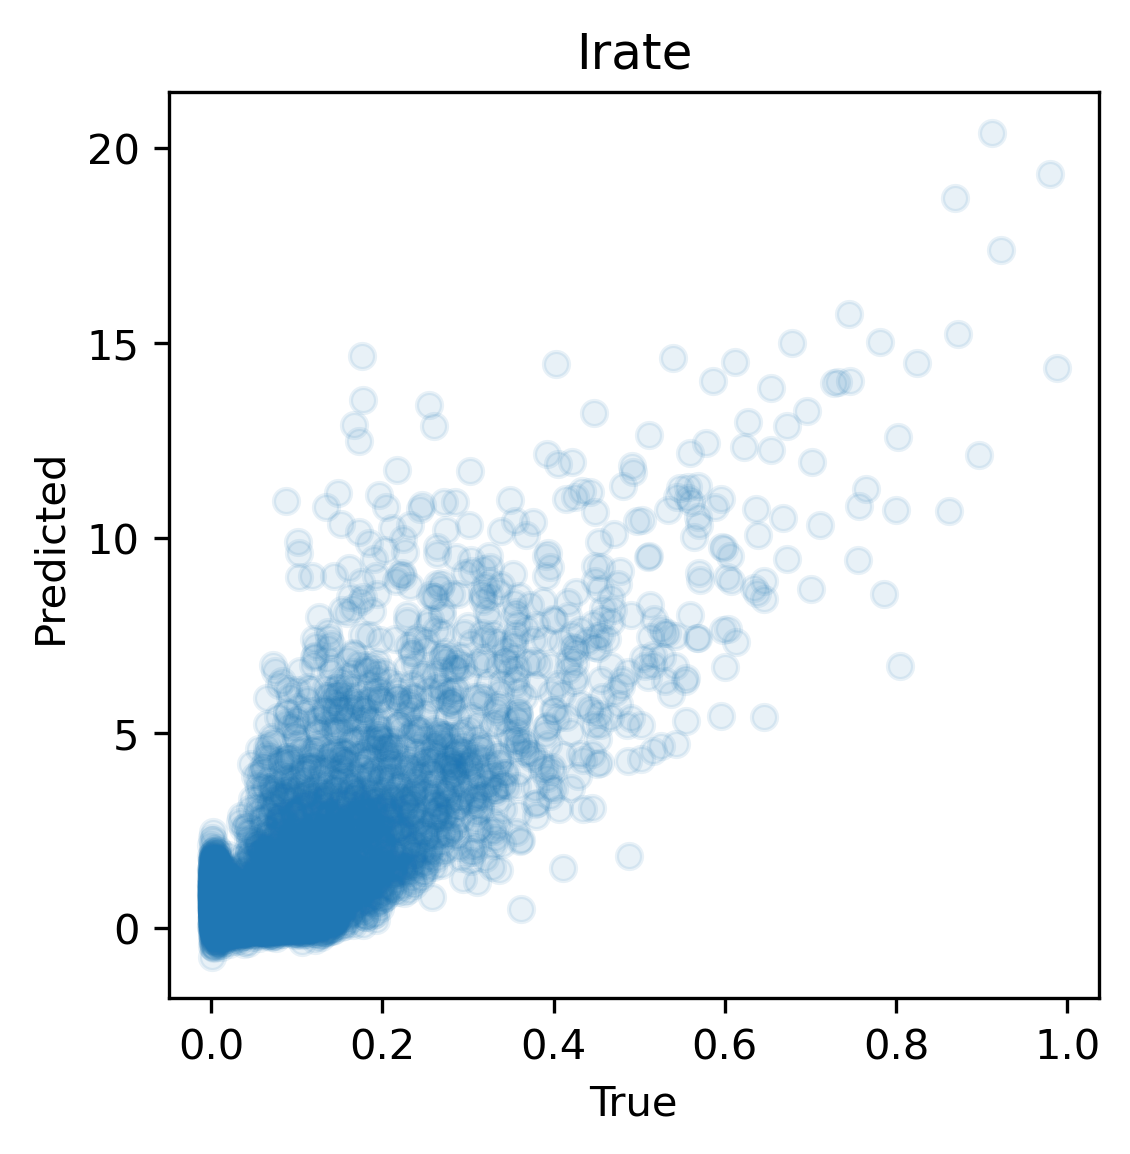

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize = (4, 4), dpi = 300)

y_predicted = model.predict(X_test)

plt.plot(y_test, y_predicted, 'o', alpha = 0.1)
plt.title('Irate')
plt.xlabel('True')
plt.ylabel('Predicted')

# SAVED MODEL BNN FROM TRAIN SCRIPT

The previous code is to show what is happening. But training is done in scripts that are connected to WandB. That way everything is in order. 

For now, the configuration is written in the script, maybe later it will be better to have a config file.

In this script models are save according to:
- entity (wandb)
- project (wandb)
- run name (wandb)

In a particular folder in this repo (new_models), will a folder for each project and the model is the directorty. So a model has a name (run name), lastname (project) and run id (entity).

In this folder is also save a configuration file with the hyperparameters used for training, but also for loading the model and other things.

Check that script for details. Important things done there not present here:

- Model, files storage strategy using local and wandb storage.
- Data generator for applying Gaussian noise in each batch of training, very usefull actually. 

## Loading BNN for further use

It is possible to integrate test and ready for GPU models in the training script. But for now, we will train the BNNs, compare them in its raw form and then load then to apply further steps as: ensemble DNN, pre/post processing layers, etc.

In [27]:
# Load locally 

import models 
model_path = 'new_models/new_project/azure-sound-15'
model = models.load_model(model_path)


### config parameters ###
{'batch_size': 1000, 'epochs': 100, 'dataset': 'raw_datasets/dataset_sample_rec3_', 'inputs_labels': ['emi_3-2', 'emi_5-2'], 'inputs_prepro': [3, 3], 'inputs_scaler': 'StandardScaler', 'outputs_labels': ['Irate'], 'outputs_prepro': [3], 'outputs_scaler': 'MinMaxScaler', 'min_max_scale': (0, 1), 'model': 'MLP_BNN_model_Denseflipout_2', 'last_bayes_layer': 100, 'l2_regularizer': 1e-09, 'gau_noise': [0.03, 0.03], 'num_nodes': 100, 'num_layers': 5, 'optimizer': 'adam', 'activation_fn': 'relu', 'loss_fn': 'mse', 'earlystopping_patience': 4, 'inputs_mean_params': [5727052.320882813, 2143770.632412159], 'inputs_scale_params': [5705031.11886095, 1876906.453418592], 'outputs_min_params': [123510.05061008346], 'outputs_scale_params': [7.3252145223985786e-09], 'wand_run_id': 'z2ij2bj6'}
#########################


/Users/jaimecaballero/miniforge3/envs/epfl2/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/jaimecaballero/miniforge3/envs/epfl2/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


  1/234 [..............................] - ETA: 1:00

2023-11-15 10:51:32.780275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


234/234 [==============================] - 1s 6ms/step


Text(0, 0.5, 'Predicted')

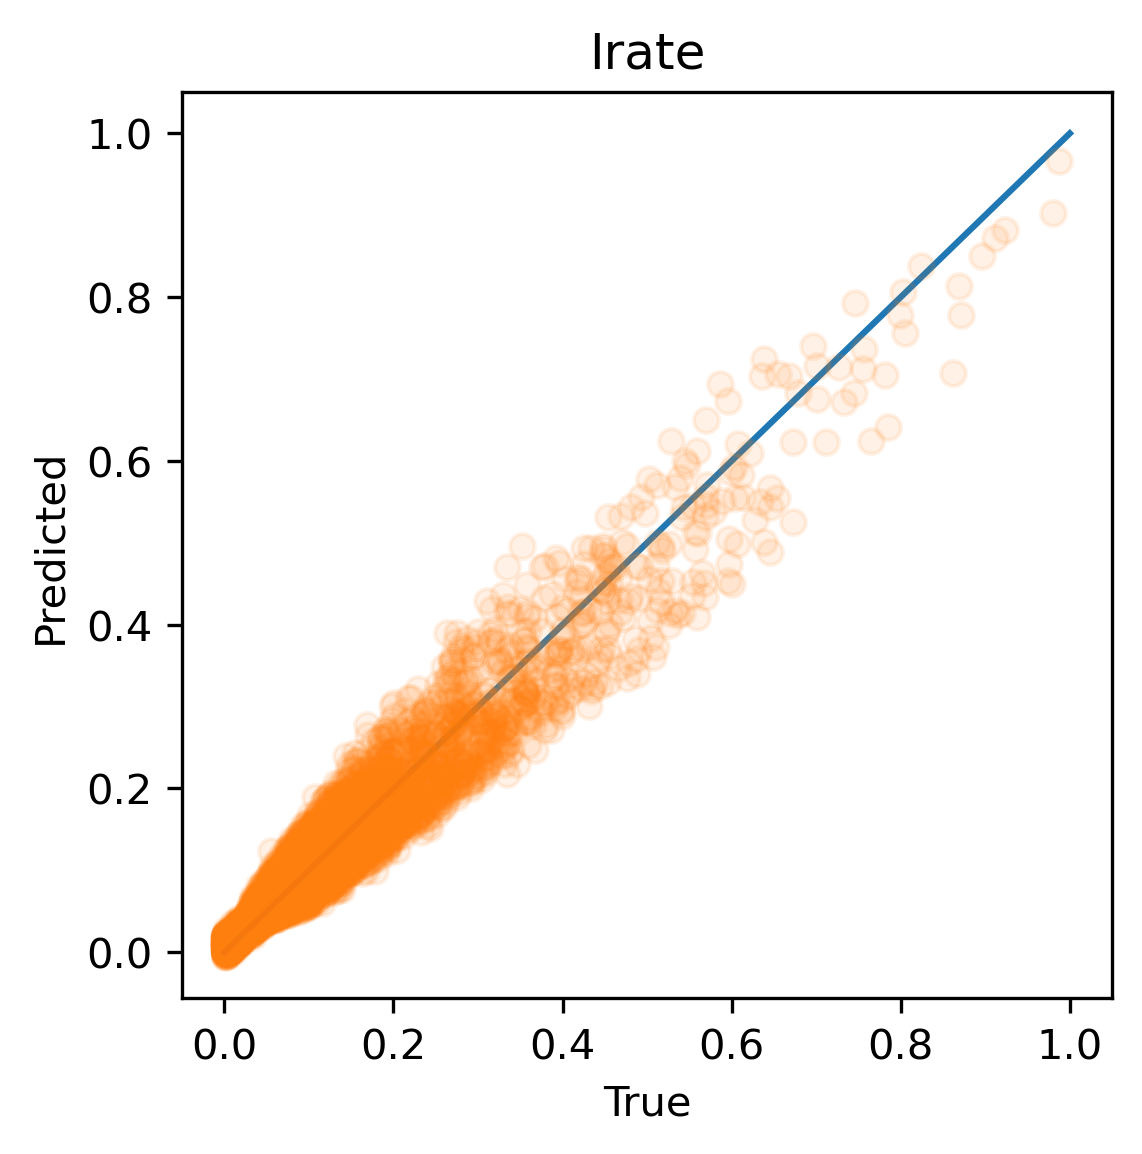

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize = (4, 4), dpi = 300)

iterations = 10
predictions = np.zeros((X_test.shape[0], y_test.shape[1], iterations))
for i in range(iterations):
    predictions[:, :, i] = model.predict(X_test)
y_predicted = np.mean(predictions.copy(), axis = 2)

plt.plot([0, 1], [0, 1])
plt.plot(y_test, y_predicted, 'o', alpha = 0.1)

plt.title('Irate')
plt.xlabel('True')
plt.ylabel('Predicted')

In [25]:
# In case a specific model within the training wants to be test 
# and it is in wandb 

# the first argument in this function is the wandb <entity>/<project>/<run_id>
# the second argument is the path found in the artifact of the model version 
# in wandb 

model = models.load_model_from_wandb('jaimejaimec016/new_project/ojc584ju',\
     'jaimejaimec016/new_project/run_ojc584ju_model:v19')



### config parameters ###
{'model': 'MLP_BNN_model_Denseflipout_2', 'epochs': 10, 'dataset': 'raw_datasets/dataset_sample_rec3_', 'loss_fn': 'mse', 'gau_noise': [0.05, 0.05], 'num_nodes': 100, 'optimizer': 'adam', 'batch_size': 1000, 'num_layers': 5, 'activation_fn': 'relu', 'inputs_labels': ['emi_3-2', 'emi_5-2'], 'inputs_prepro': [3, 3], 'inputs_scaler': 'StandardScaler', 'min_max_scale': [0, 1], 'l2_regularizer': 1e-09, 'outputs_labels': ['Irate'], 'outputs_prepro': [3], 'outputs_scaler': 'MinMaxScaler', 'last_bayes_layer': 100, 'inputs_mean_params': [5727052.320882813, 2143770.632412159], 'outputs_min_params': [123510.05061008346], 'inputs_scale_params': [5705031.11886095, 1876906.453418592], 'outputs_scale_params': [7.3252145223985786e-09], 'earlystopping_patience': 4}
#########################


/Users/jaimecaballero/miniforge3/envs/epfl2/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/jaimecaballero/miniforge3/envs/epfl2/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


wandb:   4 of 4 files downloaded.  
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  1/234 [..............................] - ETA: 54s

2023-11-14 17:00:12.787172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


234/234 [==============================] - 1s 6ms/step


Text(0, 0.5, 'Predicted')

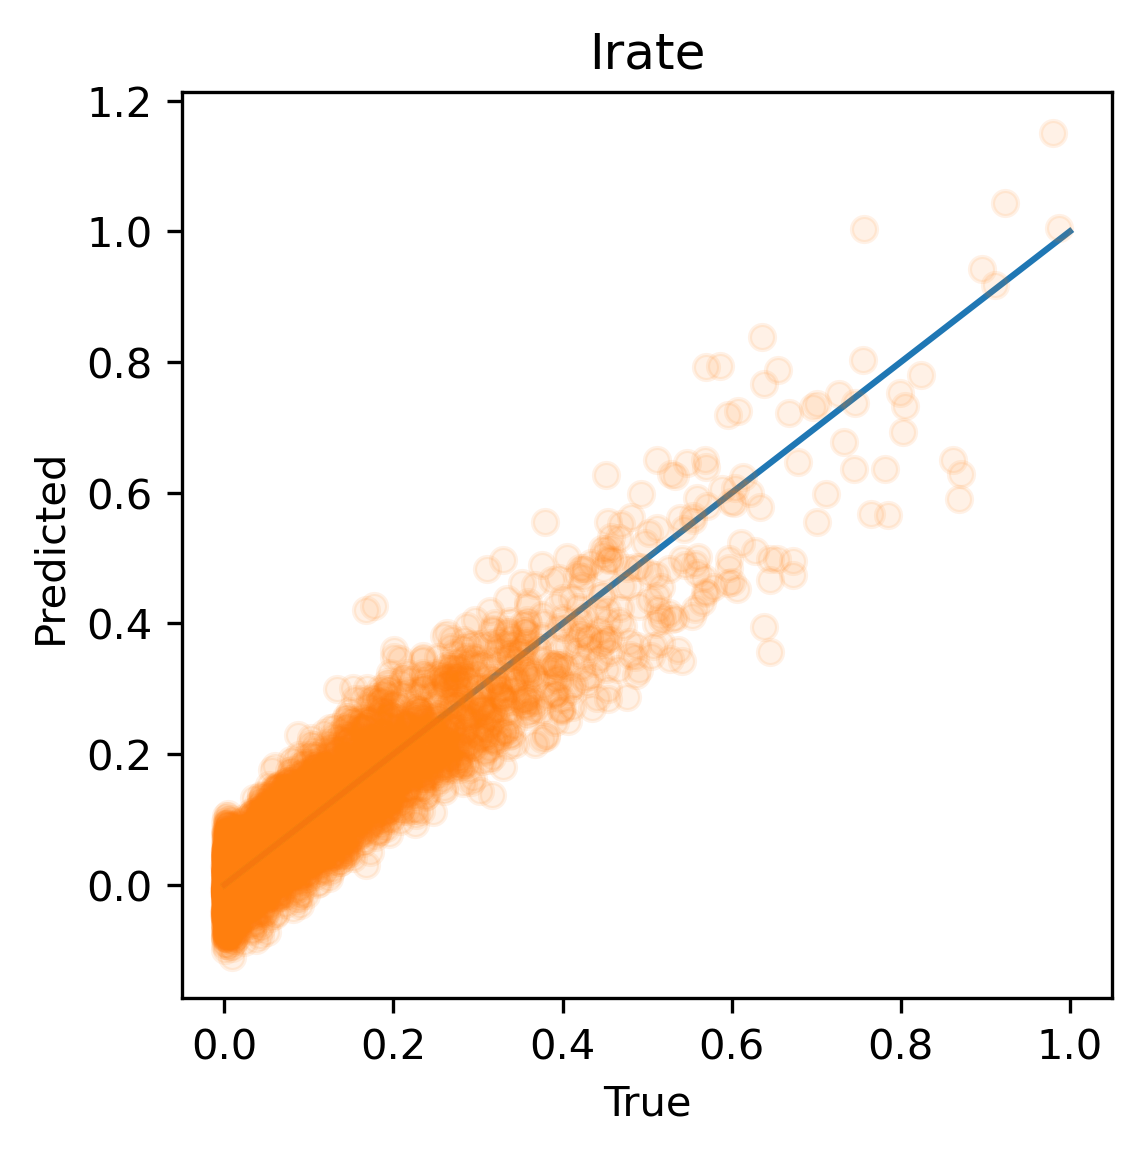

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize = (4, 4), dpi = 300)

iterations = 10
predictions = np.zeros((X_test.shape[0], y_test.shape[1], iterations))
for i in range(iterations):
    predictions[:, :, i] = model.predict(X_test)
y_predicted = np.mean(predictions.copy(), axis = 2)

plt.plot([0, 1], [0, 1])
plt.plot(y_test, y_predicted, 'o', alpha = 0.1)

plt.title('Irate')
plt.xlabel('True')
plt.ylabel('Predicted')

# From BNN to parallel DNN

Something to be done here is to make functions that does that by grabbing a model and its configuration file. Also the option to load dataset for testing or whatever. 

## Sampling posterior of bayesian model 

In [61]:
# SAMPLING KERNEL POSTERIOR
print(model.layers[-2].kernel_posterior.sample())

tf.Tensor(
[[-1.7314888  -0.18725911  1.3110086  ... -0.42930517 -0.63891035
  -0.54329425]
 [-0.698776    2.2578676   0.73215705 ... -0.6535735   0.18692675
  -0.6653889 ]
 [ 0.957601    0.03373882  0.6793065  ... -1.7365861   0.73837525
   1.8275914 ]
 ...
 [-1.2845118   0.2654358   0.4271908  ... -1.8026102   0.37233686
  -0.87742525]
 [ 0.29226846  0.3597111   0.6574246  ...  0.40943155 -0.6803508
   1.7564327 ]
 [ 0.57713336 -0.17708032  0.15987779 ...  0.987863    1.179088
   0.01465473]], shape=(100, 100), dtype=float32)


In [66]:
# SAMPLING BIAS POSTERIOR
print(model.layers[-2].bias_posterior.sample())

tf.Tensor(
[ 0.02576816  0.01244945  0.11238389 -0.17116265 -0.00394969  0.07486293
  0.03794603 -0.13666339 -0.21902998 -0.07468902  0.11692144 -0.10049388
 -0.01819663 -0.12205041 -0.15067141 -0.25269428 -0.37994388  0.09453771
  0.02385956 -0.4337218  -0.06460602  0.00727085  0.0187665  -0.10406581
 -0.08520076 -0.04648946 -0.06897141 -0.20448081 -0.07490452 -0.20559824
 -0.15269752 -0.21057041 -0.05798522 -0.15485415 -0.10454185  0.01825808
 -0.16502742 -0.14701368 -0.3892854  -0.12552844 -0.03372591 -0.07294148
 -0.05282933  0.09785802 -0.23453087 -0.06535318 -0.10832415 -0.27499545
 -0.19884339 -0.15479973 -0.17784607 -0.08928762 -0.1502015  -0.09655539
 -0.2457955  -0.2429832   0.01217924 -0.21929955 -0.02216003 -0.18092702
  0.01286125  0.05958832 -0.08713479  0.01634232  0.08709769  0.22487867
 -0.40034932 -0.17454714 -0.00115431 -0.27568954 -0.0326107   0.05920682
 -0.16166277 -0.15593202 -0.08661558 -0.13198496  0.00195238 -0.21851501
  0.11761468 -0.10281721 -0.1839371   0.

## Making architectue DNN equivalent of BNN

In [67]:
# in here a new deterministic model is declared, with the same architecture as 
# BNN 

# !!!!! LATER THIS WILL BE IMPLEMENTED IN A MODULE !!!!!

n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]

num_layers = sweep_configuration['parameters']['num_layers']['values'][0]

num_nodes = sweep_configuration['parameters']['num_nodes']['values'][0]

last_bayes_layer = sweep_configuration['parameters']['last_bayes_layer']['values'][0]


if sweep_configuration['parameters']['model']['values'][0] == 'MLP_BNN_model_Denseflipout_2':

        kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] *1.0)

        # DETERMINISTIC MODEL
        model_1 = models.MLP_BNN_model_book_2_dummy(n_inputs, n_outputs, \
                                        num_layers, num_nodes, last_bayes_layer, \
                                        act_fn = sweep_configuration['parameters']['activation_fn']['value'], \
                                        l2_reg = sweep_configuration['parameters']['l2_regularizer']['value'], \
                                        gau_noise = 0, \
                                        kernel_div = kernel_divergence_fn) # gaussian noise is apply in the training loop

print(model_1.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               300       
                                                                 
 batch_normalization_20 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_21 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_22 (Bat  (None, 100)             

In [68]:
model.layers[-2].__class__.__name__

'DenseFlipout'

## Transfer weights from BNN to DNN

In [71]:

# METHOD FOR TRANSFERING WEIGHTS FROM BAYESIAN TO DETERMINISTIC MODEL
for idx, layer in enumerate(model.layers):

    if layer.__class__.__name__ != 'DenseFlipout':
        model_1.layers[idx].set_weights(model.layers[idx].get_weights())
    else:
        sampled_weights = []
        sampled_weights.append(model.layers[idx].kernel_posterior.sample())
        sampled_weights.append(model.layers[idx].bias_posterior.sample())
        model_1.layers[idx].set_weights(sampled_weights)
        
print('successfully transfer weights')
        


tf.Tensor(
[ 0.02576816  0.01244945  0.11238389 -0.17116265 -0.00394969  0.07486293
  0.03794603 -0.13666339 -0.21902998 -0.07468902  0.11692144 -0.10049388
 -0.01819663 -0.12205041 -0.15067141 -0.25269428 -0.37994388  0.09453771
  0.02385956 -0.4337218  -0.06460602  0.00727085  0.0187665  -0.10406581
 -0.08520076 -0.04648946 -0.06897141 -0.20448081 -0.07490452 -0.20559824
 -0.15269752 -0.21057041 -0.05798522 -0.15485415 -0.10454185  0.01825808
 -0.16502742 -0.14701368 -0.3892854  -0.12552844 -0.03372591 -0.07294148
 -0.05282933  0.09785802 -0.23453087 -0.06535318 -0.10832415 -0.27499545
 -0.19884339 -0.15479973 -0.17784607 -0.08928762 -0.1502015  -0.09655539
 -0.2457955  -0.2429832   0.01217924 -0.21929955 -0.02216003 -0.18092702
  0.01286125  0.05958832 -0.08713479  0.01634232  0.08709769  0.22487867
 -0.40034932 -0.17454714 -0.00115431 -0.27568954 -0.0326107   0.05920682
 -0.16166277 -0.15593202 -0.08661558 -0.13198496  0.00195238 -0.21851501
  0.11761468 -0.10281721 -0.1839371   0.

## Comparison of results

In [65]:
mean_bnn  = 0
mean_det = 0
num = 10
for i in range(num):

    current_bnn = model.predict(X_test[0:1, :], verbose=0)[0][0]

    # making another deterministic network with sampling 

    for idx, layer in enumerate(model.layers):

        if layer.__class__.__name__ != 'DenseFlipout':
            model_1.layers[idx].set_weights(model.layers[idx].get_weights())
        else:
            sampled_weights = []
            sampled_weights.append(model.layers[idx].kernel_posterior.sample())
            sampled_weights.append(model.layers[idx].bias_posterior.sample())
            model_1.layers[idx].set_weights(sampled_weights)

    current_det = model_1.predict(X_test[0:1, :], verbose=0)[0][0]

    mean_bnn += current_bnn
    mean_det += current_det

# code to check my version of tensorflow probability
# import tensorflow_probability as tfp
# tfp.__version__

print("Average BNN: ", mean_bnn/num)
print("Average DNNs: ", mean_det/num)



Average BNN:  0.024420355446636677
Average DNNs:  0.02788743916898966


# Concatenate multiple DNN into one network

In here we are making an ensemble of DNN into one architecture to improve speed by using presample bayesian networks. 

In [66]:

# Declare single network with functional API keras 
from tensorflow.keras.layers import Input, Dense, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


# jaja que risa 
num_networks = 8

networks_list = []

networks_input_list = []

# NETWORK 1
for i in range(num_networks):

    input_single = Input(shape=(n_inputs,))
    # POSSIBLE TO PUT PREPROCESSING HERE WITH NO INPUT LAYER 
    # AND THEN CREATE A BIG INPUT LAYER FOR ALL THE NETWORKS
    x = Dense(num_nodes, activation='relu')(input_single)
    x = BatchNormalization()(x)
    for i in range(num_layers - 2):
            x = Dense(num_nodes, activation='relu')(x)
            x = BatchNormalization()(x)
    x = Dense(num_nodes, activation='relu')(x)
    output_single = Dense(n_outputs)(x)
    
    
    networks_list.append(output_single)
    networks_input_list.append(input_single)

merged_models = concatenate(networks_list)

model_merged = Model(inputs=networks_input_list, outputs=merged_models)

model_merged.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 2)]          0           []                               
                                                                                              

In [67]:
# FILL MULTIPLE NETWORKS WITH SAME WEIGHTS AND DIFFERENT BAYESIAN SAMPLES OF BAYESIAN LAYER 

for idx in range(num_networks, len(model_merged.layers) - 1, num_networks):

    idx_og_model = int(idx/num_networks - 1)

    for idx_layer in range(idx, idx+num_networks):


        if model.layers[idx_og_model].__class__.__name__ != 'DenseFlipout':

            model_merged.layers[idx_layer].set_weights(model.layers[idx_og_model].get_weights())

        else:

            sampled_weights = []
            sampled_weights.append(model.layers[idx_og_model].kernel_posterior.sample())
            sampled_weights.append(model.layers[idx_og_model].bias_posterior.sample())
            model_merged.layers[idx_layer].set_weights(sampled_weights)
            

In [71]:
mean_bnn  = 0
mean_det = 0
num = num_networks
for i in range(num):

    current_bnn = model.predict(X_test[0:1, :], verbose=0)[0][0]

    # making another deterministic network with sampling 

    for idx, layer in enumerate(model.layers):

        if layer.__class__.__name__ != 'DenseFlipout':
            model_1.layers[idx].set_weights(model.layers[idx].get_weights())
        else:
            sampled_weights = []
            sampled_weights.append(model.layers[idx].kernel_posterior.sample())
            sampled_weights.append(model.layers[idx].bias_posterior.sample())
            model_1.layers[idx].set_weights(sampled_weights)

    current_det = model_1.predict(X_test[0:1, :], verbose=0)[0][0]

    mean_bnn += current_bnn
    mean_det += current_det

# code to check my version of tensorflow probability
# import tensorflow_probability as tfp
# tfp.__version__

print("Average BNN: ", mean_bnn/num)
print("Average DNNs: ", mean_det/num)
print("Average single multiple DNN: ", np.mean(model_merged([X_test[0:1, :]]*num_networks).numpy()))

Average BNN:  0.019448498380370438
Average DNNs:  0.026638521812856197
Average single multiple DNN:  0.029921336


In [433]:
%timeit model_merged([X_test[0:200, :]]*num_networks)

10.5 ms ± 80.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Save merged model

In [377]:
# SAVE TEST MODEL 

model_merged.save('new_models/merged_model_9_trial')

INFO:tensorflow:Assets written to: new_models/merged_model_9_trial/assets


INFO:tensorflow:Assets written to: new_models/merged_model_9_trial/assets


In [378]:
model_merged_saved = tf.keras.models.load_model('new_models/merged_model_9_trial')

# Check if it possible to have an input output layer with pre and post processing

First in single model 

In [72]:
# This function gives gets the scaler parameters for the inputs and outputs of the model 
print(data.get_scalers(inputs_labels, inputs_prepro, inputs_scaler, \
                                                                outputs_labels, outputs_prepro, outputs_scaler, \
                                                                data_folder=sweep_configuration['parameters']['dataset']['value']))


----PARQUET FILES FOUND-----
([5727052.320882813, 2143770.632412159], [5705031.11886095, 1876906.453418592], [123510.05061008346], [7.3252145223985786e-09], 60189)


## Declaring pre/post processing layers 

In [142]:

from tensorflow.keras.layers import Layer
import tensorflow as tf

class Pre_processingLayer(Layer):

    def __init__(self, inputs_prepo, inputs_mean_params, inputs_scale_params, **kwargs):

        super(Pre_processingLayer, self).__init__(**kwargs)
        self.inputs_prepo = tf.constant(inputs_prepo, dtype=tf.float32)
        self.inputs_mean_params = tf.constant(inputs_mean_params, dtype=tf.float32)
        self.inputs_scale_params = tf.constant(inputs_scale_params, dtype=tf.float32)

    def call(self, inputs):

        # applying compression if needed
        return (tf.pow(inputs, 1/self.inputs_prepo) - self.inputs_mean_params)/self.inputs_scale_params


class Post_processingLayer(Layer):

    def __init__(self, outputs_prepo, outputs_min_params, outputs_scale_params, **kwargs):

        super(Post_processingLayer, self).__init__(**kwargs)
        self.outputs_prepo = tf.constant(outputs_prepo, dtype=tf.float32)
        self.outputs_min_params = tf.constant(outputs_min_params, dtype=tf.float32)
        self.outputs_scale_params = tf.constant(outputs_scale_params, dtype=tf.float32)

    def call(self, inputs):

        # applying compression if needed
        return tf.pow(inputs/self.outputs_scale_params + self.outputs_min_params, self.outputs_prepo)



## Making emsenble of networks with pre/post processing layers 

In [170]:

# Declare single network with functional API keras 
from tensorflow.keras.layers import Input, Dense, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


# Declare networks with pre and post processing layers 

# jaja que risa 
num_networks = 5

networks_list = []

networks_input_list = []

# NETWORK 1
for i in range(num_networks):

    input_single = Input(shape=(n_inputs,))
    # POSSIBLE TO PUT PREPROCESSING HERE WITH NO INPUT LAYER 
    # AND THEN CREATE A BIG INPUT LAYER FOR ALL THE NETWORKS
    x = Pre_processingLayer([3, 3], [5727052.320882813, 2143770.632412159], [5705031.11886095, 1876906.453418592])(input_single)
    x = Dense(num_nodes, activation='relu')(x)
    x = BatchNormalization()(x)
    for i in range(num_layers - 2):
            x = Dense(num_nodes, activation='relu')(x)
            x = BatchNormalization()(x)
    x = Dense(num_nodes, activation='relu')(x)
    x = Dense(n_outputs)(x)
    output_single = Post_processingLayer([3], [123510.05061008346], [7.3252145223985786e-09])(x)

    # HERE ADD POST PREOCESSING LAYER 
    
    networks_list.append(output_single)
    networks_input_list.append(input_single)

merged_models = concatenate(networks_list)

model_merged = Model(inputs=networks_input_list, outputs=merged_models)

model_merged.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 input_47 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 input_48 (InputLayer)          [(None, 2)]          0           []                               
                                                                                            

## Filling the networks with BNN weights

In [171]:
# FILL MULTIPLE NETWORKS WITH SAME WEIGHTS AND DIFFERENT BAYESIAN SAMPLES OF BAYESIAN LAYER 
# the little *2 and -2 is to skip the preprocessing layer
for idx in range(num_networks*2, len(model_merged.layers) - (1 + num_networks), num_networks):

    idx_og_model = int(idx/num_networks - 2)

    for idx_layer in range(idx, idx+num_networks):

        if model.layers[idx_og_model].__class__.__name__ != 'DenseFlipout':

            model_merged.layers[idx_layer].set_weights(model.layers[idx_og_model].get_weights())

        else:

            sampled_weights = []
            sampled_weights.append(model.layers[idx_og_model].kernel_posterior.sample())
            sampled_weights.append(model.layers[idx_og_model].bias_posterior.sample())
            model_merged.layers[idx_layer].set_weights(sampled_weights)

In [172]:
#4.013282e+21	7.606742e+20	2.959380e+20


# 6.539686e+19	1.801201e+19	7.858138e+18	2.528655e+18	5.839376	6.905135e+19	1.441993e+15	0.999979	3.277210e+20

test_data = X_test[0:1, :].copy()

test_data[0, :] = [6.539686e+19, 7.858138e+18]

print(test_data)
print(3.277210e+20)
print(model_merged([test_data]*num_networks))
print(np.mean(model_merged([test_data]*num_networks)))

[[6.539686e+19 7.858138e+18]]
3.27721e+20
tf.Tensor([[2.1196394e+20 5.0242606e+19 1.5651435e+20 2.4185991e+20 6.2074358e+19]], shape=(1, 5), dtype=float32)
1.4453104e+20


In [25]:
%timeit model_merged([test_data]*num_networks)

NameError: name 'model_merged' is not defined

In [173]:
# save model
model_merged.save('new_models/merged_model_withprepost_trial')

INFO:tensorflow:Assets written to: new_models/merged_model_withprepost_trial/assets


In [174]:
model_merged_1 = tf.keras.models.load_model('new_models/merged_model_withprepost_trial')

In [1]:
import models
model_path = 'new_models/experiment_1/light-blaze-10'
model_ensemble = models.BNN_ensemble_DNN(model_path=model_path)

### config parameters ###
{'batch_size': 10000, 'epochs': 60, 'dataset': 'raw_datasets/dataset_IrateRrate_rec3_0_', 'inputs_labels': ['emi_3-2', 'emi_5-2', '728/706', '728/668'], 'inputs_prepro': [3, 3, 1, 1], 'inputs_scaler': 'StandardScaler', 'outputs_labels': ['Te', 'ne', 'no', 'IrateRrate', 'Rrate'], 'outputs_prepro': [1, 3, 3, 3, 3], 'outputs_scaler': 'MinMaxScaler', 'min_max_scale': (0, 10), 'model': 'MLP_BNN_model_Denseflipout_2', 'last_bayes_layer': 100, 'l2_regularizer': 1e-06, 'gau_noise': [0.03, 0.03, 0.01, 0.01], 'num_nodes': 100, 'num_layers': 5, 'optimizer': 'adam', 'activation_fn': 'relu', 'loss_fn': 'mse', 'earlystopping_patience': 4, 'inputs_mean_params': [11145831.099505248, 2971453.3027733923, 0.20980752705121644, 0.26253048043693894], 'inputs_scale_params': [11904147.6010717, 2778113.9784198804, 0.1489771801622918, 0.13439417231459685], 'outputs_min_params': [0.7622330987047234, 1000000.4732044463, 100000.2109434198, 676029.5563194216, 200175.53883896177], 'outputs_

2023-11-20 17:34:29.437513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-20 17:34:29.437632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/jaimecaballero/miniforge3/envs/epfl2/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/jaimecaballero/miniforge3/envs/epfl2/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a futur

In [2]:
model_ensemble.config_params


{'batch_size': 10000,
 'epochs': 60,
 'dataset': 'raw_datasets/dataset_IrateRrate_rec3_0_',
 'inputs_labels': ['emi_3-2', 'emi_5-2', '728/706', '728/668'],
 'inputs_prepro': [3, 3, 1, 1],
 'inputs_scaler': 'StandardScaler',
 'outputs_labels': ['Te', 'ne', 'no', 'IrateRrate', 'Rrate'],
 'outputs_prepro': [1, 3, 3, 3, 3],
 'outputs_scaler': 'MinMaxScaler',
 'min_max_scale': (0, 10),
 'model': 'MLP_BNN_model_Denseflipout_2',
 'last_bayes_layer': 100,
 'l2_regularizer': 1e-06,
 'gau_noise': [0.03, 0.03, 0.01, 0.01],
 'num_nodes': 100,
 'num_layers': 5,
 'optimizer': 'adam',
 'activation_fn': 'relu',
 'loss_fn': 'mse',
 'earlystopping_patience': 4,
 'inputs_mean_params': [11145831.099505248,
  2971453.3027733923,
  0.20980752705121644,
  0.26253048043693894],
 'inputs_scale_params': [11904147.6010717,
  2778113.9784198804,
  0.1489771801622918,
  0.13439417231459685],
 'outputs_min_params': [0.7622330987047234,
  1000000.4732044463,
  100000.2109434198,
  676029.5563194216,
  200175.5388389

In [5]:
num_networks = 8
model_ready = model_ensemble.ensemble_DNN(num_networks=num_networks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 4)]          0           []                               
                                                                                              

In [18]:
import numpy as np 
from sklearn.metrics import r2_score as r2_score_metric

# making predictions
predictions_raw = model_ready([X_test]*num_networks)
# reshaping predictions
predictions_raw = np.reshape(predictions, (y_test.shape[0], y_test.shape[1], num_networks), order='F')
# convert to Irate 

predictions = predictions_raw.copy()
predictions[:, 3, :] = predictions_raw[:, 3, :] - predictions_raw[:, -1, :]

y_predict_realspace = np.mean(predictions.copy(), axis = 2)
y_predict_std_realspace = (100*np.std(predictions.copy(), axis = 2, dtype = np.float64))/y_predict_realspace
 


In [21]:
X_test, y_test = model_ensemble.load_test_set()
outputs_labels = model_ensemble.config_params['outputs_labels']
print(outputs_labels)

# y_test convert 
print(y_test)
y_test[:, 3] = y_test[:, 3] - y_test[:, -1]
print(y_test)
# print(y_test.shape)
# print(y_predict_realspace.shape)

Getting data from folder:  raw_datasets/dataset_IrateRrate_rec3_0_
----PARQUET FILES FOUND-----
['Te', 'ne', 'no', 'IrateRrate', 'Rrate']
[[1.61708140e+00 1.92973276e+19 1.27746745e+18 3.31523853e+20
  1.79827964e+20]
 [1.20906671e+01 1.04047612e+18 5.41597887e+16 5.08372634e+20
  5.69742953e+16]
 [2.92582042e+00 2.18881837e+18 5.83532927e+15 3.28508122e+18
  9.63868396e+17]
 ...
 [3.78008120e+01 1.95589869e+18 4.67124279e+18 2.42430144e+23
  6.65244071e+16]
 [2.78013214e+01 3.56683030e+18 8.73385876e+17 7.02477079e+22
  3.01084218e+17]
 [6.99439761e+01 2.11157599e+18 1.97670029e+18 1.37536013e+23
  4.06077610e+16]]
[[1.61708140e+00 1.92973276e+19 1.27746745e+18 1.51695889e+20
  1.79827964e+20]
 [1.20906671e+01 1.04047612e+18 5.41597887e+16 5.08315660e+20
  5.69742953e+16]
 [2.92582042e+00 2.18881837e+18 5.83532927e+15 2.32121283e+18
  9.63868396e+17]
 ...
 [3.78008120e+01 1.95589869e+18 4.67124279e+18 2.42430077e+23
  6.65244071e+16]
 [2.78013214e+01 3.56683030e+18 8.73385876e+17 7.02

In [ ]:
# get I rate from test set


  Te: 0.999501 //   ne: 0.997279 //   no: 0.976506 //   IrateRrate: 0.996095 //   Rrate: 0.988176 // 

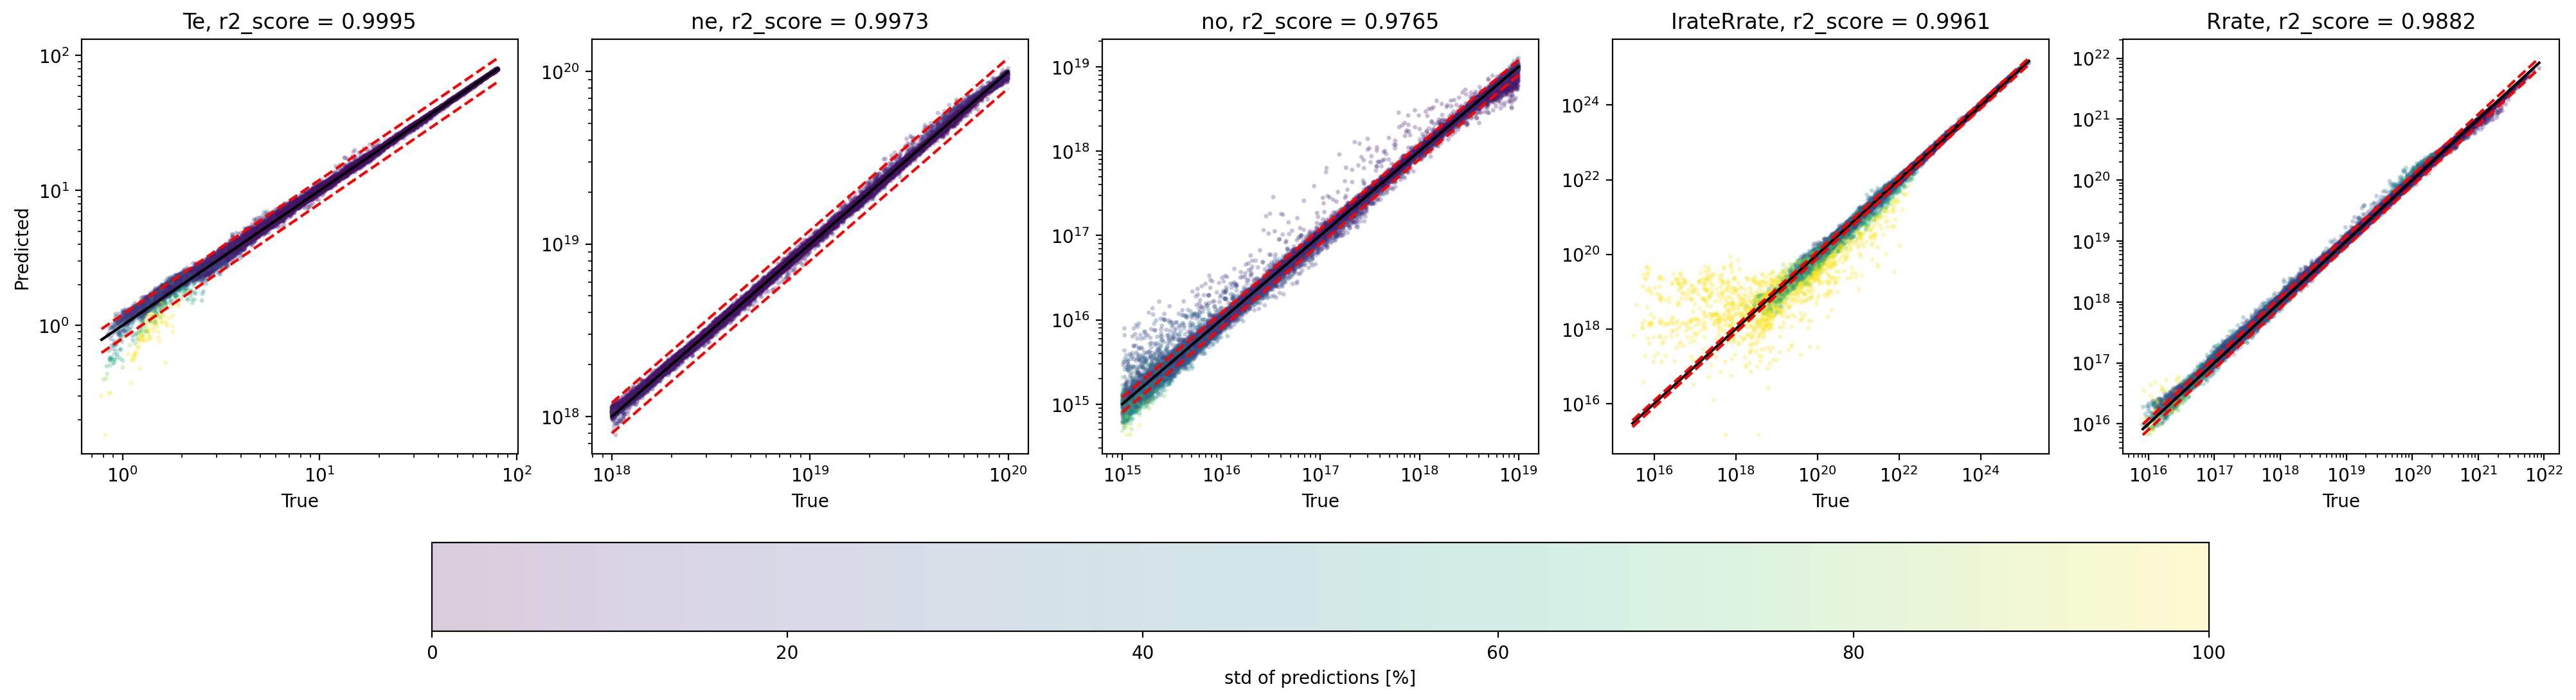

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, y_test.shape[1], figsize = (4*y_test.shape[1], 5.20), dpi = 200) 
fig.tight_layout()

for i in range(y_test.shape[1]):

    print("  " + outputs_labels[i], end= ": ")
    r2_score = r2_score_metric(y_test[:,i], y_predict_realspace[:,i])
    print('{:.6f}'.format(r2_score), end = ' // ')

    error_line_arr = np.linspace(np.min(y_test[:,i]), np.max(y_test[:,i]), 100)
        
    ax[i].plot(error_line_arr, error_line_arr, 'k-')
    ax[i].plot(error_line_arr, error_line_arr*1.2, 'r--')
    ax[i].plot(error_line_arr, error_line_arr*0.8, 'r--')
    # figure out error bars
    # ax.errorbar(y_test, mean, yerr=np.std(predictions, axis=1), fmt='o', alpha = 0.1)

    #ax[i].plot(y_test_truth_realspace[:,i], y_predict_realspace[:,i], 'o', alpha = 0.05, markersize=2)
    pcm = ax[i].scatter(y_test[:,i], y_predict_realspace[:,i], \
        c = y_predict_std_realspace[:,i], cmap = 'viridis', alpha = 0.2, s = 3, \
            vmin = 0.0, vmax = 100.0)
    
    ax[i].set_title('{}, r2_score = {:.4f}'.format(outputs_labels[i], r2_score))
    ax[i].set_xlabel('True')
    if i == 0:
        ax[i].set_ylabel('Predicted')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

    if i + 1 == y_test.shape[1]:
        # add color bar
        cbar = fig.colorbar(pcm, ax = ax, orientation = 'horizontal', location = 'bottom')
        cbar.set_label('std of predictions [%]')


# (THIS DOES NOT WORK, IGNORE) MAKE MAIN BNN INCLUDE PRE AND POST PROCESSING 

In [1]:
# Author: Jaime Caballero
# Date: 10-11-2023

# general modules

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tensorflow as tf
#from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from numpy import asarray
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score as r2_score_metric
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
import datetime
#import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras import backend as K
#import scipy.io as sio
import time
import wandb
from wandb.keras import WandbCallback
import math


# helper modules

import models
import data_loading_preprocessing as data

sweep_configuration = {
    'method': 'grid',
    'name': 'sweep',
    'metric': {'goal': 'minimize', 'name': 'val_loss'},
    'parameters':
    {
        'batch_size': {'values': [1000]}, #SWEEPED

        'epochs': {'values': [100]},  #SWEEPED

        'dataset' : {'value': 'raw_datasets/dataset_sample_rec3_'}, # dataset_name = 'raw_datasets/dataset_sample_rec3'

        'inputs_labels' : { 'value' : ['emi_3-2', 'emi_5-2']}, #Da,Dg  // Da, Db, Dg

        'inputs_prepro' : { 'value' : [3, 3]},

        'inputs_scaler' : { 'value' : 'StandardScaler'},

        'outputs_labels' : { 'value' : ['Irate']},

        'outputs_prepro' : { 'value' : [3]},

        'outputs_scaler' : { 'value' : 'MinMaxScaler'},

        'min_max_scale' : { 'value' : (0, 1)},

        'model' : { 'values' : ['MLP_BNN_model_Denseflipout_2']}, # 'MLP_NN_MCdropout' MLP_NN_simple

        'last_bayes_layer' : {'values': [100]},

        'l2_regularizer' : { 'value' : 1e-9},

        'dropout_p' : { 'value' : 0.01},

        'dropout_layers' : { 'value' : [3, 4]},

        'gau_noise': {'values': [0.05, 0.05]},

        'gau_noise_H': {'values': [0.01]},

        'gau_noise_He': {'values': [0.09]},

        'num_nodes' : { 'values' : [100]},

        'num_layers' : { 'values' : [5]},

        'optimizer' : { 'value' : 'adam'},

        'activation_fn' : { 'value' : 'relu'},

        'loss_fn' : { 'value' : 'mse'},

        'earlystopping_patience' : { 'value' : 4},

        'folder_save_model' : { 'value' : 'new_models/'}


     }
}

In [23]:
##### THE MAIN DATASET I USED: 'dataset' : {'value': 'raw_datasets/adasH_gotoHe_crm_LHS_IRrate_'}, #####
##### IS NOT IN THE REPOSITORY BECAUSE IT IS TOO BIG. #####
##### ASK TO SEND IT TO YOU IF YOU WANT TO TRY IT, BUT... I GUESS YOU WILL USE THE ONE WITH THE NEW MODEL #####


print("###### LOADING DATASET ######")
print("###### no sweep on data preprocessing ######")
inputs_labels = sweep_configuration['parameters']['inputs_labels']['value']
inputs_prepro = sweep_configuration['parameters']['inputs_prepro']['value']
inputs_scaler = StandardScaler() if sweep_configuration['parameters']['inputs_scaler']['value'] == 'StandardScaler' else MinMaxScaler()

outputs_labels = sweep_configuration['parameters']['outputs_labels']['value']
outputs_prepro = sweep_configuration['parameters']['outputs_prepro']['value']
outputs_scaler = MinMaxScaler(feature_range=sweep_configuration['parameters']['min_max_scale']['value']) \
                                    if sweep_configuration['parameters']['outputs_scaler']['value'] == 'MinMaxScaler' else StandardScaler()

X_train_real_unique, y_train_real, \
X_train, y_train, \
X_val, y_val, \
X_test, y_test, \
transform_input, inverse_input, \
transform_output, inverse_output = data.grab_data_preprocessing_2(inputs_labels, inputs_prepro, inputs_scaler, \
                                                                outputs_labels, outputs_prepro, outputs_scaler, \
                                                                data_folder=sweep_configuration['parameters']['dataset']['value'])

X_train, _ = data.data_decoder(X_train, inputs_prepro, inverse_input)
y_train, _ = data.data_decoder(y_train, outputs_prepro, inverse_output)

X_val, _ = data.data_decoder(X_val, inputs_prepro, inverse_input)
y_val, _ = data.data_decoder(y_val, outputs_prepro, inverse_output)

X_test, _ = data.data_decoder(X_test, inputs_prepro, inverse_input)
y_test, _ = data.data_decoder(y_test, outputs_prepro, inverse_output)


print("###### DATASET LOADED ######")
print("###### no sweep on data preprocessing ######")
print("###### same datapreprocessing will be use across the sweep ######")

###### LOADING DATASET ######
###### no sweep on data preprocessing ######
----PARQUET FILES FOUND-----
###### DATASET LOADED ######
###### no sweep on data preprocessing ######
###### same datapreprocessing will be use across the sweep ######


In [24]:
n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]

num_layers = sweep_configuration['parameters']['num_layers']['values'][0]

num_nodes = sweep_configuration['parameters']['num_nodes']['values'][0]

last_bayes_layer = sweep_configuration['parameters']['last_bayes_layer']['values'][0]


# This function gives gets the scaler parameters for the inputs and outputs of the model 
inputs_mean_params, inputs_scale_params, outputs_min_params, outputs_scale_params, _ = data.get_scalers(inputs_labels, inputs_prepro, inputs_scaler, \
                                                                outputs_labels, outputs_prepro, outputs_scaler, \
                                                                data_folder=sweep_configuration['parameters']['dataset']['value'])



if sweep_configuration['parameters']['model']['values'][0] == 'MLP_BNN_model_Denseflipout_2':

        kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] *1.0)

        model = models.MLP_BNN_model_book_prepost(n_inputs, n_outputs, \
                                        num_layers, num_nodes, last_bayes_layer, \
                                        act_fn = sweep_configuration['parameters']['activation_fn']['value'], \
                                        l2_reg = sweep_configuration['parameters']['l2_regularizer']['value'], \
                                        gau_noise = 0, \
                                        kernel_div = kernel_divergence_fn, \
                                        inputs_prepo = inputs_prepro, \
                                        inputs_mean_params = inputs_mean_params, \
                                        inputs_scale_params = inputs_scale_params, \
                                        outputs_prepo = outputs_prepro, \
                                        outputs_min_params = outputs_min_params, \
                                        outputs_scale_params = outputs_scale_params) 

print(model.summary())

----PARQUET FILES FOUND-----
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 pre_processing_layer_2 (Pre  (None, 2)                0         
 _processingLayer)                                               
                                                                 
 dense_10 (Dense)            (None, 100)               300       
                                                                 
 batch_normalization_8 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_9 (Batc  

/Users/jaimecaballero/miniforge3/envs/epfl/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/jaimecaballero/miniforge3/envs/epfl/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [21]:
# Set up earlystopper callback 

earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=sweep_configuration['parameters']['earlystopping_patience']['value'], verbose=0, mode='auto',
    restore_best_weights=True
    )



# Run test set evaluation on real space training data at end of each epoch
# here is where you can introduce a testing routine with real data from experimentes or similar. 

class CustomCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):

        #y_test_truth_realspace = data.data_decoder(y_val, outputs_prepro, inverse_output)[0]

        y_test_truth_realspace = y_val.copy()

        iterations = 7

        predictions = np.zeros((X_val.shape[0], y_val.shape[1], iterations))

        for i in range(iterations):

            #predictions[:, :, i] = data.data_decoder(self.model.predict(X_val, batch_size = 50000, verbose = 0), outputs_prepro, inverse_output)[0]
            predictions[:, :, i] = self.model.predict(X_val, batch_size = 50000, verbose = 0)
            
        y_predict_realspace = np.mean(predictions.copy(), axis = 2)

        print('\n---------------------------------------')

        print(' R2 scores - val set:')

        for i in range(y_train.shape[1]):

            print("  " + outputs_labels[i], end= ": ")
            r2_score = r2_score_metric(y_test_truth_realspace[:,i], y_predict_realspace[:,i])
            print('{:.6f}'.format(r2_score), end = ' // ')

            #wandb.log({outputs_labels[i] : r2_score})

        print('\n---------------------------------------')

# callbacks list, omitting wandb for now 

#wandb_callback = WandbCallback(monitor="val_loss", save_model = True, save_weights_only = True) #save_model = True)

callbacks_list = [earlystopper, CustomCallback()] #, wandb_callback

callbacks_list = [earlystopper]

# declaring number of epochs and batch size 

num_epochs = sweep_configuration['parameters']['epochs']['values'][0] # this number is the maximum, early stopping will kill the training. 

batch_size = sweep_configuration['parameters']['batch_size']['values'][0] # batch size


In [22]:
# big number of val_loss at the beginning, just for algorithm 
# this variable will keep track if val_loss does not improve
# to apply early stopping 
val_loss_check = 100

# variable for keeping track of the earlystopping patience
count_waiting = 0

for i in range(num_epochs):

    X_train_real = X_train_real_unique.copy()

    # applying different gaussian noise to each input, plus different noise in each epoch 
    # X_train_fit =  data.data_encoder(X_train_real + X_train_real * sweep_configuration['parameters']['gau_noise']['values'] * np.random.randn(X_train_real.shape[0], X_train_real.shape[1]), inputs_prepro, transform_input)[0]

    X_train_fit = X_train_real + X_train_real * sweep_configuration['parameters']['gau_noise']['values'] * np.random.randn(X_train_real.shape[0], X_train_real.shape[1])

    print(X_train_fit)
    print(y_train)

    print(X_val)
    print(y_val) 
    # train for 1 epoch, but in for loop 
    history = model.fit(X_train_fit, y_train, batch_size = batch_size, verbose=2, validation_data = (X_val, y_val), shuffle = True, epochs=1, validation_batch_size = 20000, callbacks=callbacks_list)

    print('\n epoch: {}   //    val-loss:   {}     // count to kill training:    {} \n '.format(i+1, history.history['val_loss'][-1], count_waiting))

    if history.history['val_loss'][-1] < val_loss_check:

        val_loss_check = history.history['val_loss'][-1]

        count_waiting = 0

    else:

        count_waiting = count_waiting + 1

    if count_waiting >= sweep_configuration['parameters']['earlystopping_patience']['value']:


        break




K.set_value(model.optimizer.learning_rate, 1e-6)

print('\n ##### NEW TRAINIG STEP ######## \n')

count_waiting = 0

for i in range(num_epochs):

    X_train_real = X_train_real_unique.copy()

    #X_train_fit =   data.data_encoder(X_train_real + X_train_real * sweep_configuration['parameters']['gau_noise']['values'] * np.random.randn(X_train_real.shape[0], X_train_real.shape[1]), inputs_prepro, transform_input)[0]
    X_train_fit = X_train_real + X_train_real * sweep_configuration['parameters']['gau_noise']['values'] * np.random.randn(X_train_real.shape[0], X_train_real.shape[1])
    

    history = model.fit(X_train_fit, y_train, batch_size = batch_size, verbose=2, validation_data = (X_val, y_val), shuffle = True, epochs=1, validation_batch_size = 20000, callbacks=callbacks_list)


    print('\n epoch: {}   //    val-loss:   {}     // count to kill training:    {} \n '.format(i+1, history.history['val_loss'][-1], count_waiting))


    if history.history['val_loss'][-1] < val_loss_check:

        val_loss_check = history.history['val_loss'][-1]

        count_waiting = 0

    else:

        count_waiting = count_waiting + 1

    if count_waiting >= sweep_configuration['parameters']['earlystopping_patience']['value']:


        break

[[2.29971305e+21 2.56196883e+20]
 [3.25794029e+19 1.55514785e+18]
 [3.69107743e+20 7.96438547e+18]
 ...
 [8.88514462e+16 1.80802211e+16]
 [7.16221146e+20 8.56233425e+19]
 [5.91071837e+17 9.44236674e+16]]
[[5.92509367e+21]
 [1.69760387e+20]
 [1.27907704e+21]
 ...
 [5.30479921e+16]
 [1.39836877e+21]
 [7.78137165e+17]]
[[1.27335400e+20 4.34965886e+18]
 [8.99677278e+18 1.25584814e+18]
 [8.78892915e+17 2.65310527e+17]
 ...
 [5.28908946e+20 5.25762714e+19]
 [3.06444837e+22 3.67584563e+20]
 [2.05714142e+17 6.14014750e+16]]
[[6.12602457e+20]
 [7.48722552e+18]
 [1.11359290e+17]
 ...
 [1.02202068e+21]
 [1.32308563e+24]
 [1.86019876e+16]]
61/61 - 1s - loss: nan - val_loss: nan - 1s/epoch - 21ms/step

 epoch: 1   //    val-loss:   nan     // count to kill training:    0 
 
[[2.26993823e+21 2.61309516e+20]
 [2.96061672e+19 1.55178796e+18]
 [3.70310978e+20 7.59793220e+18]
 ...
 [8.82277906e+16 1.59361654e+16]
 [7.33021400e+20 8.26743714e+19]
 [5.89049936e+17 8.93579212e+16]]
[[5.92509367e+21]
 [1.69